In [ ]:
"""
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

M2Bomber
dom.ria.com
realtor.ua
forbes.ua

Вартість в доларах із-за нестабільності курса валют 

Будівництво скоротилося, попит обвалився, але ціни не падають. Дослідження ринку нерухомості під час війни від Ernst & Young. 

Датасет для квартир
убрав паркомісце бо майже всі нулі
забрав кількість сот землі
"""


In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [3]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Ціна в $/м²  \
0                             2                       1         1644   
1                             2                       1         1500   
2                             2                       2         1656   
3                             2                       2         1417   
4                             2                       1         1500   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  Вартість  \
0                             1                          4     96996   
1                             1       

/var/folders/fv/4htbnq6d04q4hfws4ch0x0fm0000gn/T/ipykernel_29374/3292880243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


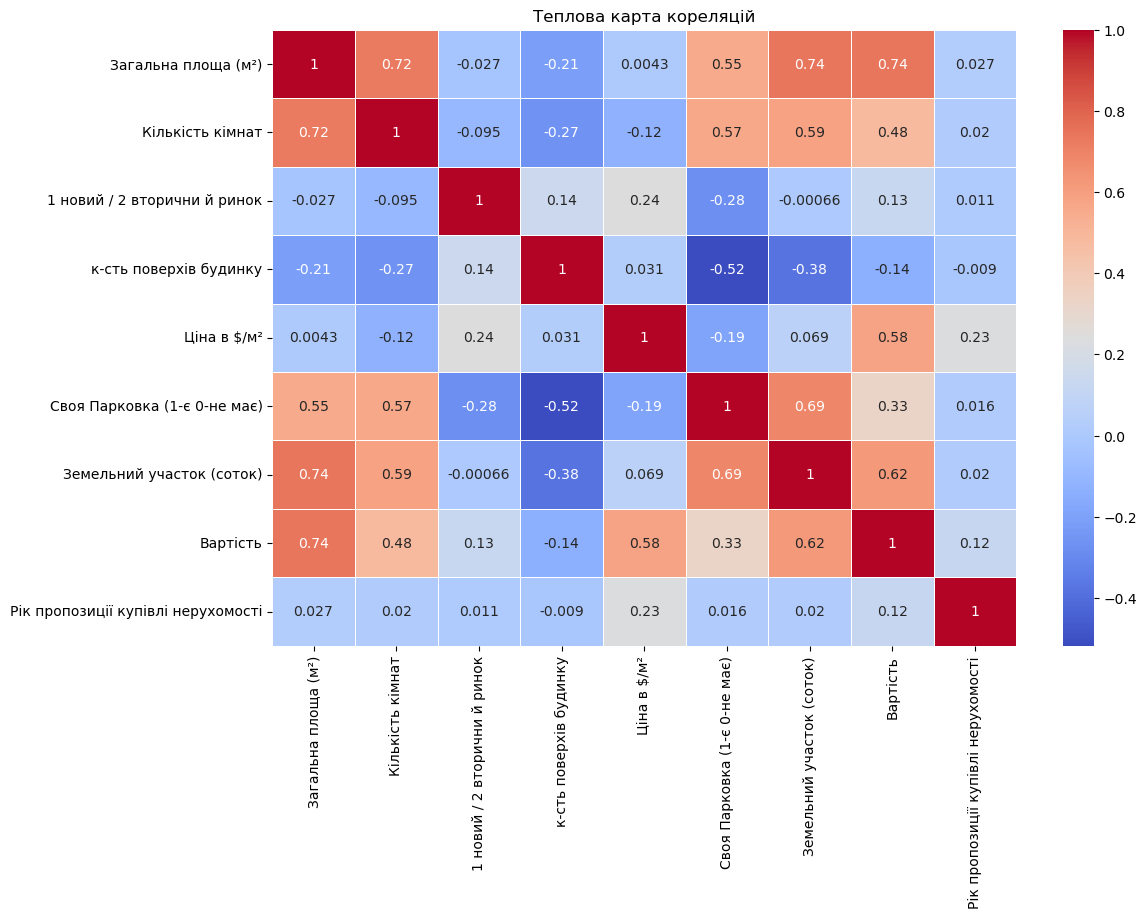

In [3]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()



In [6]:
columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)', 'Рік пропозиції купівлі нерухомості']
df = df.drop(columns=columns_to_drop, axis=1)

In [7]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Район                         2314 non-null   object
 1   Тип житла                     2314 non-null   object
 2   Загальна площа (м²)           2314 non-null   int64 
 3   Кількість кімнат              2314 non-null   int64 
 4   1 новий / 2 вторични й ринок  2314 non-null   int64 
 5   Ціна в $/м²                   2314 non-null   int64 
 6   Земельний участок (соток)     2314 non-null   int64 
 7   Вартість                      2314 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 144.8+ KB
None


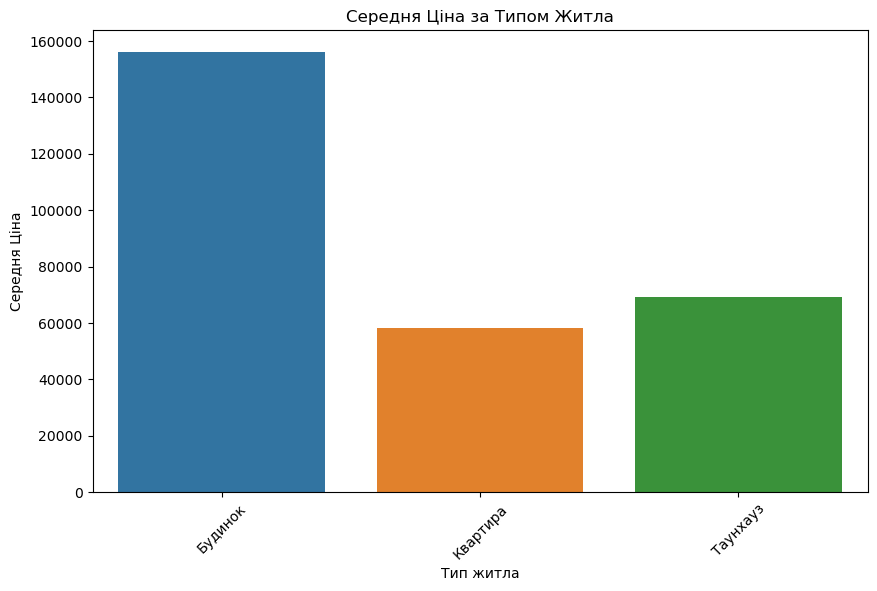

In [8]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


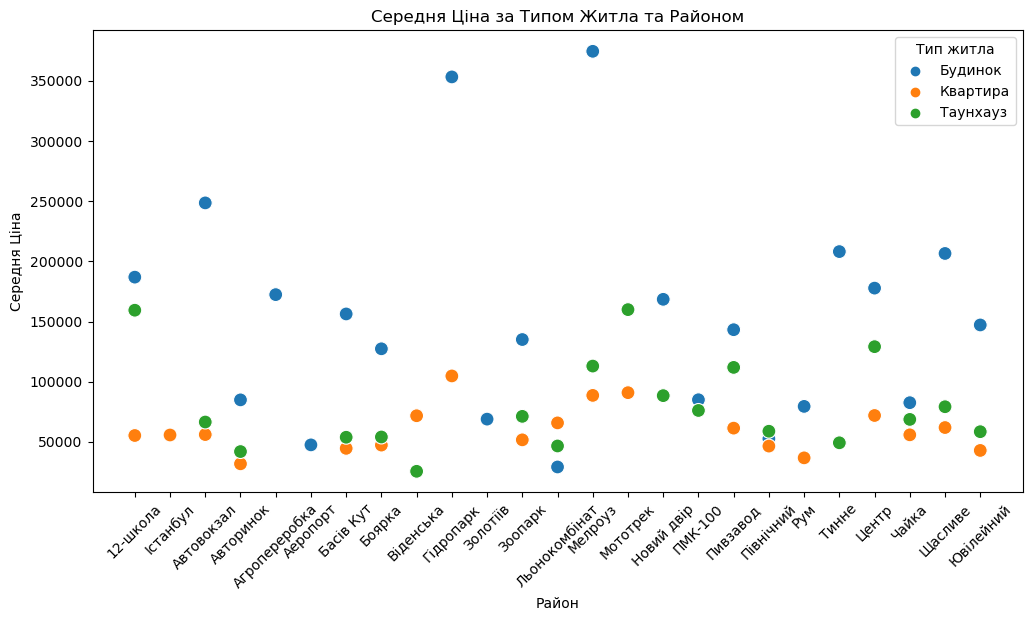

In [9]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

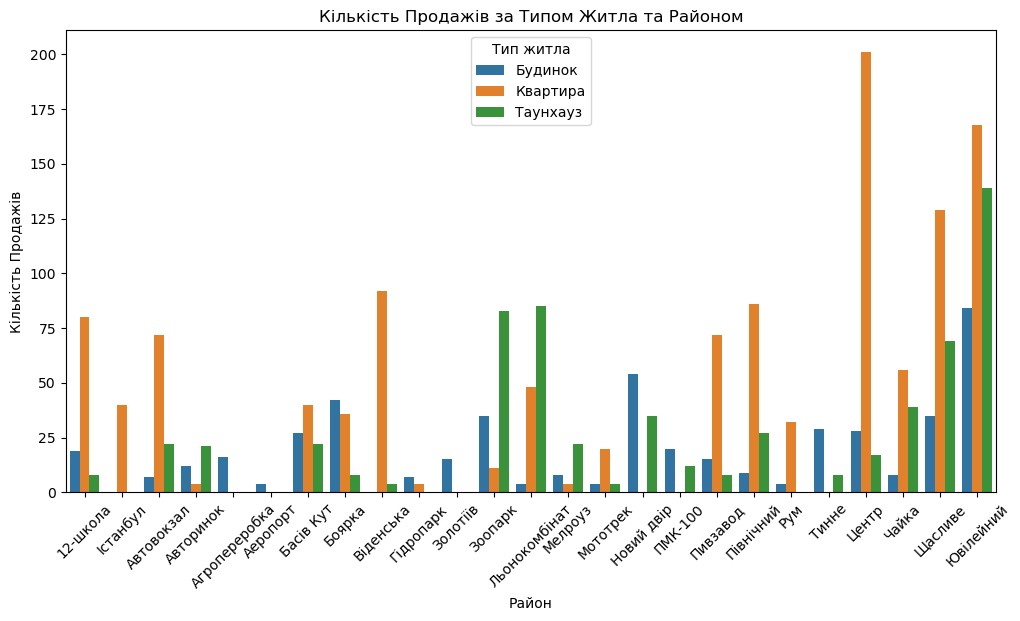

In [10]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [11]:
# Групування даних за районом і типом житла і підрахунок кількості нерухомості, що продається
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()


# Вивести всі дані з count_data у вигляді рядка
print(count_data.to_string(index=False))

        Район Тип житла  Вартість
     12-школа   Будинок        19
     12-школа  Квартира        80
     12-школа  Таунхауз         8
     Істанбул  Квартира        40
   Автовокзал   Будинок         7
   Автовокзал  Квартира        72
   Автовокзал  Таунхауз        22
    Авторинок   Будинок        12
    Авторинок  Квартира         4
    Авторинок  Таунхауз        21
Агропереробка   Будинок        16
     Аеропорт   Будинок         4
    Басів Кут   Будинок        27
    Басів Кут  Квартира        40
    Басів Кут  Таунхауз        22
       Боярка   Будинок        42
       Боярка  Квартира        36
       Боярка  Таунхауз         8
    Віденська  Квартира        92
    Віденська  Таунхауз         4
    Гідропарк   Будинок         7
    Гідропарк  Квартира         4
     Золотіїв   Будинок        15
      Зоопарк   Будинок        35
      Зоопарк  Квартира        11
      Зоопарк  Таунхауз        83
Льонокомбінат   Будинок         4
Льонокомбінат  Квартира        48
Льонокомбінат 

In [12]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

KeyError: 'Рік пропозиції купівлі нерухомості'

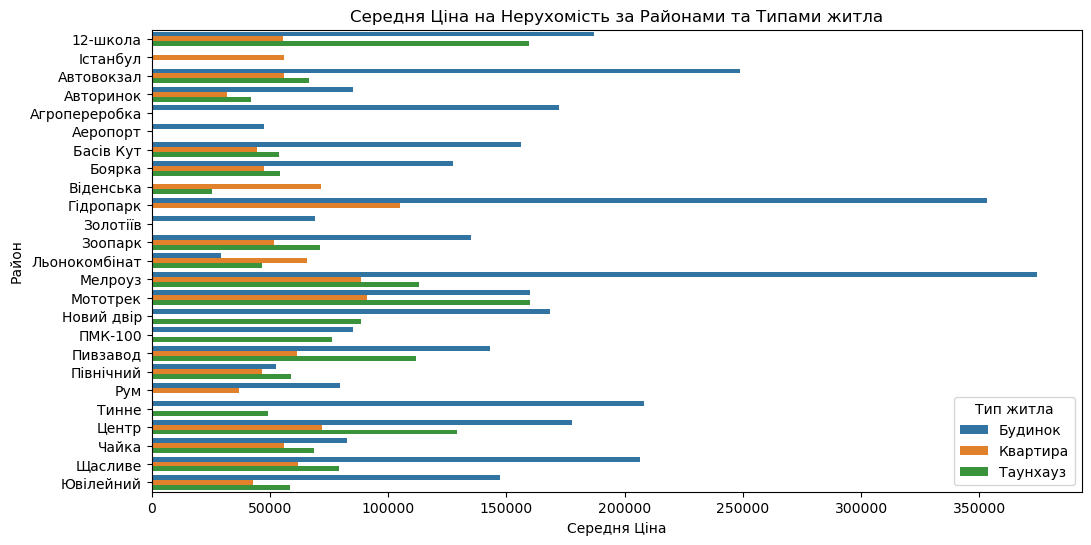

In [13]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [14]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перегляньте оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,1 новий / 2 вторични й ринок,Ціна в $/м²,Земельний участок (соток),Вартість
0,12-школа,3,59,3,2,1644,4,96996
1,12-школа,3,90,2,2,1500,6,135000
2,12-школа,2,151,3,2,1656,4,250056
3,12-школа,3,240,4,2,1417,7,340080
4,12-школа,3,90,2,2,1500,6,135000


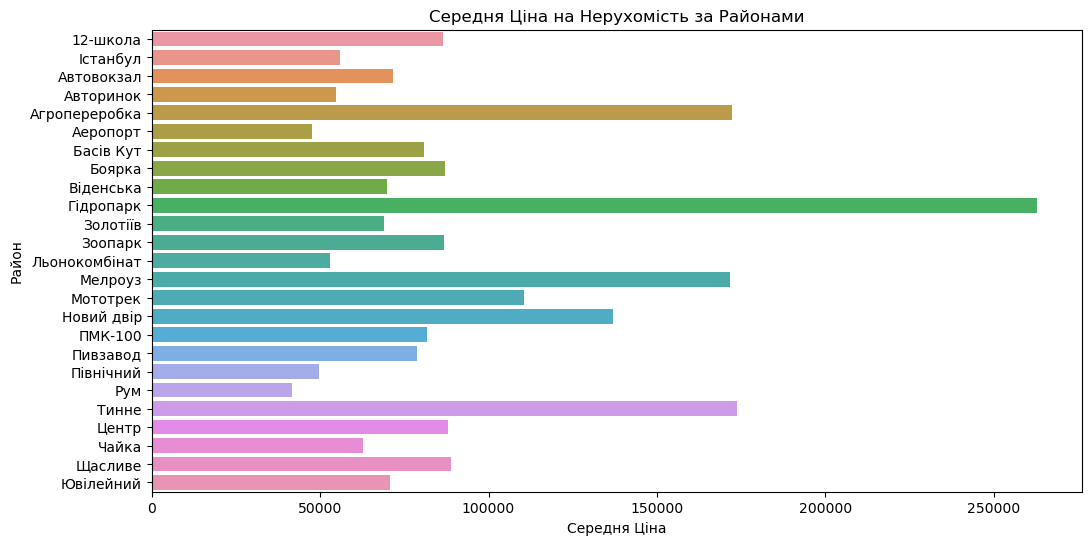

In [15]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [16]:
# тепер треба категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
df = pd.get_dummies(df, columns=['Район'])

In [17]:
# тепер пробуємо створити та навчати модель машинного навчання для задачі регресії

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизація ознак (при необхідності)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Створення та компіляція моделі
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Навчання моделі
model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Epoch 1/10000
47/47 [==============================] - 0s 1ms/step - loss: 13440422912.0000 - val_loss: 8739966976.0000
Epoch 2/10000
47/47 [==============================] - 0s 602us/step - loss: 13438409728.0000 - val_loss: 8737080320.0000
Epoch 3/10000
47/47 [==============================] - 0s 602us/step - loss: 13432472576.0000 - val_loss: 8729558016.0000
Epoch 4/10000
47/47 [==============================] - 0s 608us/step - loss: 13418077184.0000 - val_loss: 8713927680.0000
Epoch 5/10000
47/47 [==============================] - 0s 572us/step - loss: 13390234624.0000 - val_loss: 8685811712.0000
Epoch 6/10000
47/47 [==============================] - 0s 593us/step - loss: 13343813632.0000 - val_loss: 8642893824.0000
Epoch 7/10000
47/47 [==============================] - 0s 588us/step - loss: 13275523072.0000 - val_loss: 8581921280.0000
Epoch 8/10000
47/47 [==============================] - 0s 589us/step - loss: 13181677568.0000 - val_loss: 8499227648.0000
Epoch 9/10000
47/47 [=====

47/47 [==============================] - 0s 609us/step - loss: 1125529472.0000 - val_loss: 787587072.0000
Epoch 69/10000
47/47 [==============================] - 0s 596us/step - loss: 1103695616.0000 - val_loss: 776796608.0000
Epoch 70/10000
47/47 [==============================] - 0s 610us/step - loss: 1084423296.0000 - val_loss: 766415424.0000
Epoch 71/10000
47/47 [==============================] - 0s 595us/step - loss: 1062583808.0000 - val_loss: 750911232.0000
Epoch 72/10000
47/47 [==============================] - 0s 577us/step - loss: 1042951680.0000 - val_loss: 740511744.0000
Epoch 73/10000
47/47 [==============================] - 0s 600us/step - loss: 1023882304.0000 - val_loss: 744508992.0000
Epoch 74/10000
47/47 [==============================] - 0s 591us/step - loss: 1003712448.0000 - val_loss: 729160512.0000
Epoch 75/10000
47/47 [==============================] - 0s 586us/step - loss: 986507136.0000 - val_loss: 717566144.0000
Epoch 76/10000
47/47 [==========================

47/47 [==============================] - 0s 623us/step - loss: 448505888.0000 - val_loss: 473558112.0000
Epoch 137/10000
47/47 [==============================] - 0s 610us/step - loss: 446153504.0000 - val_loss: 474200960.0000
Epoch 138/10000
47/47 [==============================] - 0s 587us/step - loss: 441948928.0000 - val_loss: 467848256.0000
Epoch 139/10000
47/47 [==============================] - 0s 602us/step - loss: 438393504.0000 - val_loss: 469255776.0000
Epoch 140/10000
47/47 [==============================] - 0s 596us/step - loss: 434933024.0000 - val_loss: 465555680.0000
Epoch 141/10000
47/47 [==============================] - 0s 608us/step - loss: 431376416.0000 - val_loss: 462131040.0000
Epoch 142/10000
47/47 [==============================] - 0s 605us/step - loss: 429011200.0000 - val_loss: 459774688.0000
Epoch 143/10000
47/47 [==============================] - 0s 614us/step - loss: 425118304.0000 - val_loss: 460427968.0000
Epoch 144/10000
47/47 [=========================

Epoch 204/10000
47/47 [==============================] - 0s 604us/step - loss: 288473344.0000 - val_loss: 351486432.0000
Epoch 205/10000
47/47 [==============================] - 0s 595us/step - loss: 287207584.0000 - val_loss: 348079616.0000
Epoch 206/10000
47/47 [==============================] - 0s 602us/step - loss: 284663136.0000 - val_loss: 354694912.0000
Epoch 207/10000
47/47 [==============================] - 0s 616us/step - loss: 283424672.0000 - val_loss: 350598048.0000
Epoch 208/10000
47/47 [==============================] - 0s 614us/step - loss: 281803712.0000 - val_loss: 350273504.0000
Epoch 209/10000
47/47 [==============================] - 0s 604us/step - loss: 279932544.0000 - val_loss: 345315840.0000
Epoch 210/10000
47/47 [==============================] - 0s 583us/step - loss: 278328704.0000 - val_loss: 344455680.0000
Epoch 211/10000
47/47 [==============================] - 0s 599us/step - loss: 276600032.0000 - val_loss: 341715520.0000
Epoch 212/10000
47/47 [=========

47/47 [==============================] - 0s 594us/step - loss: 199501744.0000 - val_loss: 266180112.0000
Epoch 272/10000
47/47 [==============================] - 0s 607us/step - loss: 198821648.0000 - val_loss: 265268160.0000
Epoch 273/10000
47/47 [==============================] - 0s 630us/step - loss: 197824848.0000 - val_loss: 265826752.0000
Epoch 274/10000
47/47 [==============================] - 0s 630us/step - loss: 196549152.0000 - val_loss: 263316608.0000
Epoch 275/10000
47/47 [==============================] - 0s 624us/step - loss: 195801888.0000 - val_loss: 262253280.0000
Epoch 276/10000
47/47 [==============================] - 0s 597us/step - loss: 195246160.0000 - val_loss: 258242064.0000
Epoch 277/10000
47/47 [==============================] - 0s 618us/step - loss: 193725504.0000 - val_loss: 263264000.0000
Epoch 278/10000
47/47 [==============================] - 0s 599us/step - loss: 192862656.0000 - val_loss: 262324288.0000
Epoch 279/10000
47/47 [=========================

Epoch 339/10000
47/47 [==============================] - 0s 622us/step - loss: 151767712.0000 - val_loss: 222036896.0000
Epoch 340/10000
47/47 [==============================] - 0s 591us/step - loss: 151415520.0000 - val_loss: 221179184.0000
Epoch 341/10000
47/47 [==============================] - 0s 600us/step - loss: 151073600.0000 - val_loss: 219591632.0000
Epoch 342/10000
47/47 [==============================] - 0s 615us/step - loss: 151231984.0000 - val_loss: 224075248.0000
Epoch 343/10000
47/47 [==============================] - 0s 590us/step - loss: 149577440.0000 - val_loss: 220532944.0000
Epoch 344/10000
47/47 [==============================] - 0s 563us/step - loss: 148949952.0000 - val_loss: 219316000.0000
Epoch 345/10000
47/47 [==============================] - 0s 576us/step - loss: 148837712.0000 - val_loss: 218250384.0000
Epoch 346/10000
47/47 [==============================] - 0s 602us/step - loss: 148211616.0000 - val_loss: 219641584.0000
Epoch 347/10000
47/47 [=========

47/47 [==============================] - 0s 613us/step - loss: 123171544.0000 - val_loss: 192143088.0000
Epoch 407/10000
47/47 [==============================] - 0s 611us/step - loss: 122908696.0000 - val_loss: 192553264.0000
Epoch 408/10000
47/47 [==============================] - 0s 569us/step - loss: 122560576.0000 - val_loss: 192577888.0000
Epoch 409/10000
47/47 [==============================] - 0s 602us/step - loss: 122670768.0000 - val_loss: 190781872.0000
Epoch 410/10000
47/47 [==============================] - 0s 597us/step - loss: 121879704.0000 - val_loss: 191532720.0000
Epoch 411/10000
47/47 [==============================] - 0s 617us/step - loss: 121500768.0000 - val_loss: 192033456.0000
Epoch 412/10000
47/47 [==============================] - 0s 618us/step - loss: 121301200.0000 - val_loss: 191028688.0000
Epoch 413/10000
47/47 [==============================] - 0s 620us/step - loss: 120848968.0000 - val_loss: 188993872.0000
Epoch 414/10000
47/47 [=========================

Epoch 474/10000
47/47 [==============================] - 0s 580us/step - loss: 103703184.0000 - val_loss: 172574512.0000
Epoch 475/10000
47/47 [==============================] - 0s 571us/step - loss: 103110864.0000 - val_loss: 171349264.0000
Epoch 476/10000
47/47 [==============================] - 0s 576us/step - loss: 102974160.0000 - val_loss: 170730384.0000
Epoch 477/10000
47/47 [==============================] - 0s 574us/step - loss: 102779176.0000 - val_loss: 171024080.0000
Epoch 478/10000
47/47 [==============================] - 0s 582us/step - loss: 102533320.0000 - val_loss: 170528320.0000
Epoch 479/10000
47/47 [==============================] - 0s 571us/step - loss: 102340728.0000 - val_loss: 170861440.0000
Epoch 480/10000
47/47 [==============================] - 0s 586us/step - loss: 102101024.0000 - val_loss: 170169264.0000
Epoch 481/10000
47/47 [==============================] - 0s 570us/step - loss: 102369048.0000 - val_loss: 171295808.0000
Epoch 482/10000
47/47 [=========

47/47 [==============================] - 0s 608us/step - loss: 90375376.0000 - val_loss: 155953904.0000
Epoch 543/10000
47/47 [==============================] - 0s 600us/step - loss: 90017784.0000 - val_loss: 155017776.0000
Epoch 544/10000
47/47 [==============================] - 0s 593us/step - loss: 89981976.0000 - val_loss: 155326096.0000
Epoch 545/10000
47/47 [==============================] - 0s 591us/step - loss: 89930376.0000 - val_loss: 156360544.0000
Epoch 546/10000
47/47 [==============================] - 0s 587us/step - loss: 89627000.0000 - val_loss: 155746496.0000
Epoch 547/10000
47/47 [==============================] - 0s 575us/step - loss: 89541584.0000 - val_loss: 154892000.0000
Epoch 548/10000
47/47 [==============================] - 0s 588us/step - loss: 89716336.0000 - val_loss: 154169936.0000
Epoch 549/10000
47/47 [==============================] - 0s 589us/step - loss: 89193200.0000 - val_loss: 155107152.0000
Epoch 550/10000
47/47 [==============================] -

47/47 [==============================] - 0s 587us/step - loss: 80257016.0000 - val_loss: 140295408.0000
Epoch 611/10000
47/47 [==============================] - 0s 597us/step - loss: 80143792.0000 - val_loss: 140983808.0000
Epoch 612/10000
47/47 [==============================] - 0s 583us/step - loss: 79903432.0000 - val_loss: 141431776.0000
Epoch 613/10000
47/47 [==============================] - 0s 561us/step - loss: 79919688.0000 - val_loss: 141670608.0000
Epoch 614/10000
47/47 [==============================] - 0s 554us/step - loss: 79811896.0000 - val_loss: 141520864.0000
Epoch 615/10000
47/47 [==============================] - 0s 591us/step - loss: 79730856.0000 - val_loss: 139794832.0000
Epoch 616/10000
47/47 [==============================] - 0s 597us/step - loss: 79601608.0000 - val_loss: 140158192.0000
Epoch 617/10000
47/47 [==============================] - 0s 577us/step - loss: 79324864.0000 - val_loss: 140159776.0000
Epoch 618/10000
47/47 [==============================] -

47/47 [==============================] - 0s 603us/step - loss: 72648848.0000 - val_loss: 129861384.0000
Epoch 679/10000
47/47 [==============================] - 0s 599us/step - loss: 72476432.0000 - val_loss: 129822400.0000
Epoch 680/10000
47/47 [==============================] - 0s 597us/step - loss: 72428064.0000 - val_loss: 130569528.0000
Epoch 681/10000
47/47 [==============================] - 0s 583us/step - loss: 72275992.0000 - val_loss: 129995240.0000
Epoch 682/10000
47/47 [==============================] - 0s 583us/step - loss: 71906496.0000 - val_loss: 128823360.0000
Epoch 683/10000
47/47 [==============================] - 0s 573us/step - loss: 72025544.0000 - val_loss: 128719568.0000
Epoch 684/10000
47/47 [==============================] - 0s 553us/step - loss: 71883232.0000 - val_loss: 128588920.0000
Epoch 685/10000
47/47 [==============================] - 0s 617us/step - loss: 71738912.0000 - val_loss: 128357040.0000
Epoch 686/10000
47/47 [==============================] -

47/47 [==============================] - 0s 597us/step - loss: 66407932.0000 - val_loss: 122072936.0000
Epoch 747/10000
47/47 [==============================] - 0s 596us/step - loss: 66277524.0000 - val_loss: 121091752.0000
Epoch 748/10000
47/47 [==============================] - 0s 586us/step - loss: 66246256.0000 - val_loss: 121957768.0000
Epoch 749/10000
47/47 [==============================] - 0s 597us/step - loss: 66043900.0000 - val_loss: 120395264.0000
Epoch 750/10000
47/47 [==============================] - 0s 606us/step - loss: 66317432.0000 - val_loss: 119114392.0000
Epoch 751/10000
47/47 [==============================] - 0s 588us/step - loss: 65892024.0000 - val_loss: 120214008.0000
Epoch 752/10000
47/47 [==============================] - 0s 594us/step - loss: 65882268.0000 - val_loss: 119943720.0000
Epoch 753/10000
47/47 [==============================] - 0s 584us/step - loss: 65799208.0000 - val_loss: 120625080.0000
Epoch 754/10000
47/47 [==============================] -

47/47 [==============================] - 0s 561us/step - loss: 61201816.0000 - val_loss: 115791592.0000
Epoch 815/10000
47/47 [==============================] - 0s 576us/step - loss: 61162572.0000 - val_loss: 114638352.0000
Epoch 816/10000
47/47 [==============================] - 0s 587us/step - loss: 60979460.0000 - val_loss: 115453376.0000
Epoch 817/10000
47/47 [==============================] - 0s 568us/step - loss: 61176432.0000 - val_loss: 114549656.0000
Epoch 818/10000
47/47 [==============================] - 0s 580us/step - loss: 61127648.0000 - val_loss: 113583784.0000
Epoch 819/10000
47/47 [==============================] - 0s 572us/step - loss: 61207160.0000 - val_loss: 113737120.0000
Epoch 820/10000
47/47 [==============================] - 0s 564us/step - loss: 60873572.0000 - val_loss: 114202552.0000
Epoch 821/10000
47/47 [==============================] - 0s 564us/step - loss: 60626500.0000 - val_loss: 114709152.0000
Epoch 822/10000
47/47 [==============================] -

47/47 [==============================] - 0s 601us/step - loss: 57484996.0000 - val_loss: 109210840.0000
Epoch 883/10000
47/47 [==============================] - 0s 591us/step - loss: 57351648.0000 - val_loss: 109040656.0000
Epoch 884/10000
47/47 [==============================] - 0s 599us/step - loss: 57161844.0000 - val_loss: 109209520.0000
Epoch 885/10000
47/47 [==============================] - 0s 605us/step - loss: 57048280.0000 - val_loss: 109007952.0000
Epoch 886/10000
47/47 [==============================] - 0s 605us/step - loss: 57323000.0000 - val_loss: 110008384.0000
Epoch 887/10000
47/47 [==============================] - 0s 577us/step - loss: 57138276.0000 - val_loss: 109473968.0000
Epoch 888/10000
47/47 [==============================] - 0s 588us/step - loss: 56988856.0000 - val_loss: 109452584.0000
Epoch 889/10000
47/47 [==============================] - 0s 605us/step - loss: 56899728.0000 - val_loss: 109457440.0000
Epoch 890/10000
47/47 [==============================] -

47/47 [==============================] - 0s 614us/step - loss: 54140420.0000 - val_loss: 105620160.0000
Epoch 951/10000
47/47 [==============================] - 0s 595us/step - loss: 54156792.0000 - val_loss: 104605352.0000
Epoch 952/10000
47/47 [==============================] - 0s 622us/step - loss: 53827368.0000 - val_loss: 104901032.0000
Epoch 953/10000
47/47 [==============================] - 0s 621us/step - loss: 53811144.0000 - val_loss: 104560688.0000
Epoch 954/10000
47/47 [==============================] - 0s 615us/step - loss: 54071280.0000 - val_loss: 105240464.0000
Epoch 955/10000
47/47 [==============================] - 0s 600us/step - loss: 53803932.0000 - val_loss: 104049992.0000
Epoch 956/10000
47/47 [==============================] - 0s 581us/step - loss: 53675668.0000 - val_loss: 105026808.0000
Epoch 957/10000
47/47 [==============================] - 0s 595us/step - loss: 53670360.0000 - val_loss: 104923720.0000
Epoch 958/10000
47/47 [==============================] -

47/47 [==============================] - 0s 624us/step - loss: 50836640.0000 - val_loss: 99154808.0000
Epoch 1019/10000
47/47 [==============================] - 0s 599us/step - loss: 50902220.0000 - val_loss: 99022832.0000
Epoch 1020/10000
47/47 [==============================] - 0s 593us/step - loss: 50906632.0000 - val_loss: 100698768.0000
Epoch 1021/10000
47/47 [==============================] - 0s 595us/step - loss: 50874840.0000 - val_loss: 99685000.0000
Epoch 1022/10000
47/47 [==============================] - 0s 617us/step - loss: 50980852.0000 - val_loss: 100503168.0000
Epoch 1023/10000
47/47 [==============================] - 0s 629us/step - loss: 50683860.0000 - val_loss: 99004384.0000
Epoch 1024/10000
47/47 [==============================] - 0s 590us/step - loss: 50540212.0000 - val_loss: 99592632.0000
Epoch 1025/10000
47/47 [==============================] - 0s 586us/step - loss: 50509336.0000 - val_loss: 99540904.0000
Epoch 1026/10000
47/47 [==============================]

47/47 [==============================] - 0s 617us/step - loss: 47342720.0000 - val_loss: 93612656.0000
Epoch 1087/10000
47/47 [==============================] - 0s 630us/step - loss: 47450836.0000 - val_loss: 93553112.0000
Epoch 1088/10000
47/47 [==============================] - 0s 586us/step - loss: 47518248.0000 - val_loss: 92366456.0000
Epoch 1089/10000
47/47 [==============================] - 0s 601us/step - loss: 47273508.0000 - val_loss: 93022216.0000
Epoch 1090/10000
47/47 [==============================] - 0s 579us/step - loss: 47295864.0000 - val_loss: 94010552.0000
Epoch 1091/10000
47/47 [==============================] - 0s 585us/step - loss: 47337472.0000 - val_loss: 92797400.0000
Epoch 1092/10000
47/47 [==============================] - 0s 624us/step - loss: 47150248.0000 - val_loss: 93022392.0000
Epoch 1093/10000
47/47 [==============================] - 0s 610us/step - loss: 47138648.0000 - val_loss: 93441264.0000
Epoch 1094/10000
47/47 [==============================] -

47/47 [==============================] - 0s 601us/step - loss: 43278264.0000 - val_loss: 86743976.0000
Epoch 1155/10000
47/47 [==============================] - 0s 588us/step - loss: 43555416.0000 - val_loss: 86144016.0000
Epoch 1156/10000
47/47 [==============================] - 0s 597us/step - loss: 43019036.0000 - val_loss: 86827208.0000
Epoch 1157/10000
47/47 [==============================] - 0s 594us/step - loss: 42916024.0000 - val_loss: 86721040.0000
Epoch 1158/10000
47/47 [==============================] - 0s 599us/step - loss: 42969668.0000 - val_loss: 86081120.0000
Epoch 1159/10000
47/47 [==============================] - 0s 574us/step - loss: 42971848.0000 - val_loss: 85841280.0000
Epoch 1160/10000
47/47 [==============================] - 0s 579us/step - loss: 43052484.0000 - val_loss: 86454440.0000
Epoch 1161/10000
47/47 [==============================] - 0s 581us/step - loss: 42647832.0000 - val_loss: 86168592.0000
Epoch 1162/10000
47/47 [==============================] -

47/47 [==============================] - 0s 579us/step - loss: 38145084.0000 - val_loss: 77319000.0000
Epoch 1223/10000
47/47 [==============================] - 0s 586us/step - loss: 38215136.0000 - val_loss: 79386312.0000
Epoch 1224/10000
47/47 [==============================] - 0s 572us/step - loss: 38004664.0000 - val_loss: 77779296.0000
Epoch 1225/10000
47/47 [==============================] - 0s 578us/step - loss: 37852012.0000 - val_loss: 77711528.0000
Epoch 1226/10000
47/47 [==============================] - 0s 615us/step - loss: 37742652.0000 - val_loss: 77562744.0000
Epoch 1227/10000
47/47 [==============================] - 0s 631us/step - loss: 37736412.0000 - val_loss: 77629432.0000
Epoch 1228/10000
47/47 [==============================] - 0s 619us/step - loss: 37816812.0000 - val_loss: 78502672.0000
Epoch 1229/10000
47/47 [==============================] - 0s 619us/step - loss: 37593420.0000 - val_loss: 77185240.0000
Epoch 1230/10000
47/47 [==============================] -

47/47 [==============================] - 0s 589us/step - loss: 32132868.0000 - val_loss: 69086408.0000
Epoch 1291/10000
47/47 [==============================] - 0s 572us/step - loss: 32109336.0000 - val_loss: 67717336.0000
Epoch 1292/10000
47/47 [==============================] - 0s 548us/step - loss: 31960362.0000 - val_loss: 67957064.0000
Epoch 1293/10000
47/47 [==============================] - 0s 581us/step - loss: 31852024.0000 - val_loss: 67429016.0000
Epoch 1294/10000
47/47 [==============================] - 0s 574us/step - loss: 31692230.0000 - val_loss: 68118424.0000
Epoch 1295/10000
47/47 [==============================] - 0s 565us/step - loss: 31638838.0000 - val_loss: 67499984.0000
Epoch 1296/10000
47/47 [==============================] - 0s 561us/step - loss: 31640928.0000 - val_loss: 67549712.0000
Epoch 1297/10000
47/47 [==============================] - 0s 567us/step - loss: 31523708.0000 - val_loss: 67924224.0000
Epoch 1298/10000
47/47 [==============================] -

47/47 [==============================] - 0s 623us/step - loss: 24558258.0000 - val_loss: 54112896.0000
Epoch 1359/10000
47/47 [==============================] - 0s 618us/step - loss: 24414696.0000 - val_loss: 54354412.0000
Epoch 1360/10000
47/47 [==============================] - 0s 603us/step - loss: 24391260.0000 - val_loss: 54727064.0000
Epoch 1361/10000
47/47 [==============================] - 0s 585us/step - loss: 24338780.0000 - val_loss: 54060780.0000
Epoch 1362/10000
47/47 [==============================] - 0s 583us/step - loss: 24194468.0000 - val_loss: 52836568.0000
Epoch 1363/10000
47/47 [==============================] - 0s 595us/step - loss: 24200430.0000 - val_loss: 54638156.0000
Epoch 1364/10000
47/47 [==============================] - 0s 620us/step - loss: 23910506.0000 - val_loss: 52740376.0000
Epoch 1365/10000
47/47 [==============================] - 0s 618us/step - loss: 23811066.0000 - val_loss: 53412256.0000
Epoch 1366/10000
47/47 [==============================] -

47/47 [==============================] - 0s 624us/step - loss: 18368550.0000 - val_loss: 42324168.0000
Epoch 1427/10000
47/47 [==============================] - 0s 611us/step - loss: 18375650.0000 - val_loss: 42917328.0000
Epoch 1428/10000
47/47 [==============================] - 0s 602us/step - loss: 18264092.0000 - val_loss: 42526332.0000
Epoch 1429/10000
47/47 [==============================] - 0s 598us/step - loss: 18189826.0000 - val_loss: 41776800.0000
Epoch 1430/10000
47/47 [==============================] - 0s 629us/step - loss: 18066646.0000 - val_loss: 41914436.0000
Epoch 1431/10000
47/47 [==============================] - 0s 594us/step - loss: 17967470.0000 - val_loss: 42260820.0000
Epoch 1432/10000
47/47 [==============================] - 0s 589us/step - loss: 17930776.0000 - val_loss: 41237320.0000
Epoch 1433/10000
47/47 [==============================] - 0s 576us/step - loss: 18091836.0000 - val_loss: 40725904.0000
Epoch 1434/10000
47/47 [==============================] -

47/47 [==============================] - 0s 603us/step - loss: 14120539.0000 - val_loss: 33623132.0000
Epoch 1495/10000
47/47 [==============================] - 0s 590us/step - loss: 14079614.0000 - val_loss: 33784456.0000
Epoch 1496/10000
47/47 [==============================] - 0s 601us/step - loss: 14035348.0000 - val_loss: 33743672.0000
Epoch 1497/10000
47/47 [==============================] - 0s 622us/step - loss: 13997890.0000 - val_loss: 33332226.0000
Epoch 1498/10000
47/47 [==============================] - 0s 587us/step - loss: 13938559.0000 - val_loss: 33649224.0000
Epoch 1499/10000
47/47 [==============================] - 0s 599us/step - loss: 13863012.0000 - val_loss: 33156582.0000
Epoch 1500/10000
47/47 [==============================] - 0s 589us/step - loss: 13848438.0000 - val_loss: 33552718.0000
Epoch 1501/10000
47/47 [==============================] - 0s 585us/step - loss: 13866796.0000 - val_loss: 32964920.0000
Epoch 1502/10000
47/47 [==============================] -

47/47 [==============================] - 0s 598us/step - loss: 11284889.0000 - val_loss: 28203168.0000
Epoch 1563/10000
47/47 [==============================] - 0s 617us/step - loss: 11277833.0000 - val_loss: 26861058.0000
Epoch 1564/10000
47/47 [==============================] - 0s 601us/step - loss: 11202629.0000 - val_loss: 28051636.0000
Epoch 1565/10000
47/47 [==============================] - 0s 596us/step - loss: 11168123.0000 - val_loss: 26567788.0000
Epoch 1566/10000
47/47 [==============================] - 0s 599us/step - loss: 11763171.0000 - val_loss: 27713848.0000
Epoch 1567/10000
47/47 [==============================] - 0s 587us/step - loss: 11143654.0000 - val_loss: 27108830.0000
Epoch 1568/10000
47/47 [==============================] - 0s 599us/step - loss: 11147213.0000 - val_loss: 27186062.0000
Epoch 1569/10000
47/47 [==============================] - 0s 595us/step - loss: 11120786.0000 - val_loss: 27630840.0000
Epoch 1570/10000
47/47 [==============================] -

47/47 [==============================] - 0s 598us/step - loss: 9297082.0000 - val_loss: 23299248.0000
Epoch 1631/10000
47/47 [==============================] - 0s 628us/step - loss: 9276195.0000 - val_loss: 23497524.0000
Epoch 1632/10000
47/47 [==============================] - 0s 619us/step - loss: 9216810.0000 - val_loss: 23155124.0000
Epoch 1633/10000
47/47 [==============================] - 0s 595us/step - loss: 9264735.0000 - val_loss: 23163564.0000
Epoch 1634/10000
47/47 [==============================] - 0s 602us/step - loss: 9182703.0000 - val_loss: 23618834.0000
Epoch 1635/10000
47/47 [==============================] - 0s 631us/step - loss: 9214145.0000 - val_loss: 23169366.0000
Epoch 1636/10000
47/47 [==============================] - 0s 606us/step - loss: 9266382.0000 - val_loss: 23737804.0000
Epoch 1637/10000
47/47 [==============================] - 0s 588us/step - loss: 9144384.0000 - val_loss: 23441144.0000
Epoch 1638/10000
47/47 [==============================] - 0s 598u

Epoch 1699/10000
47/47 [==============================] - 0s 607us/step - loss: 7805163.0000 - val_loss: 20041712.0000
Epoch 1700/10000
47/47 [==============================] - 0s 595us/step - loss: 7796481.5000 - val_loss: 19913348.0000
Epoch 1701/10000
47/47 [==============================] - 0s 612us/step - loss: 7746834.5000 - val_loss: 20073576.0000
Epoch 1702/10000
47/47 [==============================] - 0s 613us/step - loss: 7742416.5000 - val_loss: 20331112.0000
Epoch 1703/10000
47/47 [==============================] - 0s 591us/step - loss: 7821532.0000 - val_loss: 20325048.0000
Epoch 1704/10000
47/47 [==============================] - 0s 586us/step - loss: 7811317.0000 - val_loss: 20211790.0000
Epoch 1705/10000
47/47 [==============================] - 0s 596us/step - loss: 7684016.5000 - val_loss: 19814786.0000
Epoch 1706/10000
47/47 [==============================] - 0s 610us/step - loss: 7681262.0000 - val_loss: 19849918.0000
Epoch 1707/10000
47/47 [========================

Epoch 1768/10000
47/47 [==============================] - 0s 587us/step - loss: 6537888.0000 - val_loss: 18220586.0000
Epoch 1769/10000
47/47 [==============================] - 0s 563us/step - loss: 6542825.0000 - val_loss: 17916094.0000
Epoch 1770/10000
47/47 [==============================] - 0s 565us/step - loss: 6576293.5000 - val_loss: 17622722.0000
Epoch 1771/10000
47/47 [==============================] - 0s 599us/step - loss: 6528380.0000 - val_loss: 17810214.0000
Epoch 1772/10000
47/47 [==============================] - 0s 564us/step - loss: 6491040.5000 - val_loss: 18242660.0000
Epoch 1773/10000
47/47 [==============================] - 0s 577us/step - loss: 6463878.0000 - val_loss: 17862008.0000
Epoch 1774/10000
47/47 [==============================] - 0s 569us/step - loss: 6491327.5000 - val_loss: 17677472.0000
Epoch 1775/10000
47/47 [==============================] - 0s 570us/step - loss: 6434248.0000 - val_loss: 17899172.0000
Epoch 1776/10000
47/47 [========================

Epoch 1837/10000
47/47 [==============================] - 0s 561us/step - loss: 5413803.0000 - val_loss: 16216068.0000
Epoch 1838/10000
47/47 [==============================] - 0s 563us/step - loss: 5444958.5000 - val_loss: 16252815.0000
Epoch 1839/10000
47/47 [==============================] - 0s 570us/step - loss: 5358879.0000 - val_loss: 15879332.0000
Epoch 1840/10000
47/47 [==============================] - 0s 561us/step - loss: 5492916.0000 - val_loss: 16163407.0000
Epoch 1841/10000
47/47 [==============================] - 0s 560us/step - loss: 5332729.5000 - val_loss: 16059897.0000
Epoch 1842/10000
47/47 [==============================] - 0s 555us/step - loss: 5394269.0000 - val_loss: 15962091.0000
Epoch 1843/10000
47/47 [==============================] - 0s 573us/step - loss: 5312095.0000 - val_loss: 15792912.0000
Epoch 1844/10000
47/47 [==============================] - 0s 612us/step - loss: 5287962.5000 - val_loss: 15559541.0000
Epoch 1845/10000
47/47 [========================

Epoch 1906/10000
47/47 [==============================] - 0s 612us/step - loss: 4527974.5000 - val_loss: 14040337.0000
Epoch 1907/10000
47/47 [==============================] - 0s 595us/step - loss: 4475410.5000 - val_loss: 14473077.0000
Epoch 1908/10000
47/47 [==============================] - 0s 601us/step - loss: 4507952.5000 - val_loss: 13855155.0000
Epoch 1909/10000
47/47 [==============================] - 0s 603us/step - loss: 4516256.0000 - val_loss: 13967490.0000
Epoch 1910/10000
47/47 [==============================] - 0s 571us/step - loss: 4496450.0000 - val_loss: 14044105.0000
Epoch 1911/10000
47/47 [==============================] - 0s 574us/step - loss: 4475150.5000 - val_loss: 13830434.0000
Epoch 1912/10000
47/47 [==============================] - 0s 561us/step - loss: 4448076.0000 - val_loss: 14352225.0000
Epoch 1913/10000
47/47 [==============================] - 0s 572us/step - loss: 4402686.5000 - val_loss: 14600567.0000
Epoch 1914/10000
47/47 [========================

Epoch 1975/10000
47/47 [==============================] - 0s 615us/step - loss: 3725892.7500 - val_loss: 13226909.0000
Epoch 1976/10000
47/47 [==============================] - 0s 595us/step - loss: 3769841.5000 - val_loss: 13155919.0000
Epoch 1977/10000
47/47 [==============================] - 0s 588us/step - loss: 3837327.0000 - val_loss: 13000474.0000
Epoch 1978/10000
47/47 [==============================] - 0s 627us/step - loss: 3750934.7500 - val_loss: 13280662.0000
Epoch 1979/10000
47/47 [==============================] - 0s 606us/step - loss: 3741310.2500 - val_loss: 12721258.0000
Epoch 1980/10000
47/47 [==============================] - 0s 607us/step - loss: 3725121.5000 - val_loss: 12818638.0000
Epoch 1981/10000
47/47 [==============================] - 0s 597us/step - loss: 3710985.2500 - val_loss: 12561263.0000
Epoch 1982/10000
47/47 [==============================] - 0s 598us/step - loss: 3745003.0000 - val_loss: 12924528.0000
Epoch 1983/10000
47/47 [========================

Epoch 2044/10000
47/47 [==============================] - 0s 595us/step - loss: 3251000.7500 - val_loss: 11311630.0000
Epoch 2045/10000
47/47 [==============================] - 0s 579us/step - loss: 3195901.5000 - val_loss: 11664511.0000
Epoch 2046/10000
47/47 [==============================] - 0s 584us/step - loss: 3208000.2500 - val_loss: 11515903.0000
Epoch 2047/10000
47/47 [==============================] - 0s 574us/step - loss: 3182915.5000 - val_loss: 11435762.0000
Epoch 2048/10000
47/47 [==============================] - 0s 547us/step - loss: 3199946.5000 - val_loss: 11440476.0000
Epoch 2049/10000
47/47 [==============================] - 0s 575us/step - loss: 3223309.5000 - val_loss: 10957999.0000
Epoch 2050/10000
47/47 [==============================] - 0s 571us/step - loss: 3174480.5000 - val_loss: 11474397.0000
Epoch 2051/10000
47/47 [==============================] - 0s 571us/step - loss: 3187137.5000 - val_loss: 11397486.0000
Epoch 2052/10000
47/47 [========================

Epoch 2113/10000
47/47 [==============================] - 0s 584us/step - loss: 2766089.2500 - val_loss: 10295684.0000
Epoch 2114/10000
47/47 [==============================] - 0s 579us/step - loss: 2744139.2500 - val_loss: 10384115.0000
Epoch 2115/10000
47/47 [==============================] - 0s 562us/step - loss: 2724977.7500 - val_loss: 10000414.0000
Epoch 2116/10000
47/47 [==============================] - 0s 552us/step - loss: 2716699.5000 - val_loss: 10008909.0000
Epoch 2117/10000
47/47 [==============================] - 0s 568us/step - loss: 2714142.0000 - val_loss: 10491587.0000
Epoch 2118/10000
47/47 [==============================] - 0s 592us/step - loss: 2716577.5000 - val_loss: 10965844.0000
Epoch 2119/10000
47/47 [==============================] - 0s 585us/step - loss: 2709589.0000 - val_loss: 9877732.0000
Epoch 2120/10000
47/47 [==============================] - 0s 574us/step - loss: 2784245.5000 - val_loss: 10502945.0000
Epoch 2121/10000
47/47 [=========================

47/47 [==============================] - 0s 602us/step - loss: 2369622.2500 - val_loss: 8987050.0000
Epoch 2183/10000
47/47 [==============================] - 0s 597us/step - loss: 2430793.7500 - val_loss: 9308522.0000
Epoch 2184/10000
47/47 [==============================] - 0s 570us/step - loss: 2366693.2500 - val_loss: 9060141.0000
Epoch 2185/10000
47/47 [==============================] - 0s 568us/step - loss: 2376199.0000 - val_loss: 10037297.0000
Epoch 2186/10000
47/47 [==============================] - 0s 566us/step - loss: 2371542.2500 - val_loss: 9695917.0000
Epoch 2187/10000
47/47 [==============================] - 0s 591us/step - loss: 2369228.7500 - val_loss: 9935673.0000
Epoch 2188/10000
47/47 [==============================] - 0s 577us/step - loss: 2352725.2500 - val_loss: 9318615.0000
Epoch 2189/10000
47/47 [==============================] - 0s 579us/step - loss: 2415061.0000 - val_loss: 9959320.0000
Epoch 2190/10000
47/47 [==============================] - 0s 594us/step 

47/47 [==============================] - 0s 626us/step - loss: 2152520.7500 - val_loss: 8939080.0000
Epoch 2252/10000
47/47 [==============================] - 0s 652us/step - loss: 2076320.7500 - val_loss: 8851304.0000
Epoch 2253/10000
47/47 [==============================] - 0s 607us/step - loss: 2080687.6250 - val_loss: 9443948.0000
Epoch 2254/10000
47/47 [==============================] - 0s 608us/step - loss: 2077098.8750 - val_loss: 9173035.0000
Epoch 2255/10000
47/47 [==============================] - 0s 624us/step - loss: 2052814.8750 - val_loss: 9054167.0000
Epoch 2256/10000
47/47 [==============================] - 0s 621us/step - loss: 2045030.6250 - val_loss: 9030611.0000
Epoch 2257/10000
47/47 [==============================] - 0s 594us/step - loss: 2046940.3750 - val_loss: 8885092.0000
Epoch 2258/10000
47/47 [==============================] - 0s 594us/step - loss: 2045602.6250 - val_loss: 8855925.0000
Epoch 2259/10000
47/47 [==============================] - 0s 595us/step -

47/47 [==============================] - 0s 613us/step - loss: 1836743.2500 - val_loss: 8225266.0000
Epoch 2321/10000
47/47 [==============================] - 0s 600us/step - loss: 1822410.2500 - val_loss: 8409786.0000
Epoch 2322/10000
47/47 [==============================] - 0s 631us/step - loss: 1857603.6250 - val_loss: 8974666.0000
Epoch 2323/10000
47/47 [==============================] - 0s 616us/step - loss: 1827343.7500 - val_loss: 8676164.0000
Epoch 2324/10000
47/47 [==============================] - 0s 580us/step - loss: 1833116.0000 - val_loss: 8093433.0000
Epoch 2325/10000
47/47 [==============================] - 0s 630us/step - loss: 1803961.6250 - val_loss: 8388173.5000
Epoch 2326/10000
47/47 [==============================] - 0s 624us/step - loss: 1794096.3750 - val_loss: 8298251.0000
Epoch 2327/10000
47/47 [==============================] - 0s 610us/step - loss: 1809010.1250 - val_loss: 8218427.5000
Epoch 2328/10000
47/47 [==============================] - 0s 640us/step -

47/47 [==============================] - 0s 593us/step - loss: 1658904.7500 - val_loss: 7912178.0000
Epoch 2390/10000
47/47 [==============================] - 0s 626us/step - loss: 1655445.1250 - val_loss: 7655974.0000
Epoch 2391/10000
47/47 [==============================] - 0s 598us/step - loss: 1630439.2500 - val_loss: 7875611.5000
Epoch 2392/10000
47/47 [==============================] - 0s 572us/step - loss: 1643268.5000 - val_loss: 8446452.0000
Epoch 2393/10000
47/47 [==============================] - 0s 631us/step - loss: 1630175.2500 - val_loss: 7677696.0000
Epoch 2394/10000
47/47 [==============================] - 0s 599us/step - loss: 1596083.7500 - val_loss: 7873908.5000
Epoch 2395/10000
47/47 [==============================] - 0s 612us/step - loss: 1606553.2500 - val_loss: 7576309.5000
Epoch 2396/10000
47/47 [==============================] - 0s 588us/step - loss: 1632017.1250 - val_loss: 7704061.0000
Epoch 2397/10000
47/47 [==============================] - 0s 616us/step -

47/47 [==============================] - 0s 600us/step - loss: 1549681.1250 - val_loss: 7249313.5000
Epoch 2459/10000
47/47 [==============================] - 0s 601us/step - loss: 1468429.8750 - val_loss: 7231457.0000
Epoch 2460/10000
47/47 [==============================] - 0s 619us/step - loss: 1456367.0000 - val_loss: 7344574.5000
Epoch 2461/10000
47/47 [==============================] - 0s 592us/step - loss: 1468881.2500 - val_loss: 7295571.5000
Epoch 2462/10000
47/47 [==============================] - 0s 602us/step - loss: 1470301.2500 - val_loss: 7161469.5000
Epoch 2463/10000
47/47 [==============================] - 0s 606us/step - loss: 1444721.0000 - val_loss: 7446593.0000
Epoch 2464/10000
47/47 [==============================] - 0s 629us/step - loss: 1454966.1250 - val_loss: 7158856.0000
Epoch 2465/10000
47/47 [==============================] - 0s 607us/step - loss: 1438926.5000 - val_loss: 7424462.5000
Epoch 2466/10000
47/47 [==============================] - 0s 594us/step -

47/47 [==============================] - 0s 637us/step - loss: 1464716.6250 - val_loss: 6600624.5000
Epoch 2528/10000
47/47 [==============================] - 0s 620us/step - loss: 1332876.7500 - val_loss: 6926080.0000
Epoch 2529/10000
47/47 [==============================] - 0s 608us/step - loss: 1334645.7500 - val_loss: 6950908.0000
Epoch 2530/10000
47/47 [==============================] - 0s 606us/step - loss: 1331226.5000 - val_loss: 6996151.0000
Epoch 2531/10000
47/47 [==============================] - 0s 600us/step - loss: 1334654.0000 - val_loss: 6870913.0000
Epoch 2532/10000
47/47 [==============================] - 0s 607us/step - loss: 1300553.5000 - val_loss: 7045375.5000
Epoch 2533/10000
47/47 [==============================] - 0s 610us/step - loss: 1314376.5000 - val_loss: 7071379.0000
Epoch 2534/10000
47/47 [==============================] - 0s 626us/step - loss: 1305222.1250 - val_loss: 7392354.0000
Epoch 2535/10000
47/47 [==============================] - 0s 593us/step -

47/47 [==============================] - 0s 618us/step - loss: 1229127.3750 - val_loss: 6601868.0000
Epoch 2597/10000
47/47 [==============================] - 0s 640us/step - loss: 1184692.6250 - val_loss: 6191200.0000
Epoch 2598/10000
47/47 [==============================] - 0s 642us/step - loss: 1223490.3750 - val_loss: 6461297.0000
Epoch 2599/10000
47/47 [==============================] - 0s 654us/step - loss: 1203135.2500 - val_loss: 6486306.0000
Epoch 2600/10000
47/47 [==============================] - 0s 639us/step - loss: 1198149.5000 - val_loss: 6418096.5000
Epoch 2601/10000
47/47 [==============================] - 0s 621us/step - loss: 1219040.2500 - val_loss: 6329536.0000
Epoch 2602/10000
47/47 [==============================] - 0s 605us/step - loss: 1239889.2500 - val_loss: 6285339.5000
Epoch 2603/10000
47/47 [==============================] - 0s 598us/step - loss: 1203636.6250 - val_loss: 6396298.0000
Epoch 2604/10000
47/47 [==============================] - 0s 647us/step -

47/47 [==============================] - 0s 609us/step - loss: 1099781.6250 - val_loss: 6360826.5000
Epoch 2666/10000
47/47 [==============================] - 0s 609us/step - loss: 1101366.8750 - val_loss: 6502350.5000
Epoch 2667/10000
47/47 [==============================] - 0s 610us/step - loss: 1109286.8750 - val_loss: 6599226.5000
Epoch 2668/10000
47/47 [==============================] - 0s 603us/step - loss: 1107900.6250 - val_loss: 6651938.5000
Epoch 2669/10000
47/47 [==============================] - 0s 591us/step - loss: 1086652.6250 - val_loss: 6479580.0000
Epoch 2670/10000
47/47 [==============================] - 0s 561us/step - loss: 1062323.2500 - val_loss: 6515390.5000
Epoch 2671/10000
47/47 [==============================] - 0s 591us/step - loss: 1091771.6250 - val_loss: 6560503.0000
Epoch 2672/10000
47/47 [==============================] - 0s 585us/step - loss: 1086732.3750 - val_loss: 6111341.5000
Epoch 2673/10000
47/47 [==============================] - 0s 587us/step -

47/47 [==============================] - 0s 611us/step - loss: 1005930.8750 - val_loss: 6201404.5000
Epoch 2735/10000
47/47 [==============================] - 0s 611us/step - loss: 1007741.3125 - val_loss: 5905112.0000
Epoch 2736/10000
47/47 [==============================] - 0s 598us/step - loss: 1031368.7500 - val_loss: 6366313.0000
Epoch 2737/10000
47/47 [==============================] - 0s 594us/step - loss: 1057776.6250 - val_loss: 6135097.5000
Epoch 2738/10000
47/47 [==============================] - 0s 548us/step - loss: 1024185.9375 - val_loss: 6345655.0000
Epoch 2739/10000
47/47 [==============================] - 0s 593us/step - loss: 1029393.3750 - val_loss: 6363583.0000
Epoch 2740/10000
47/47 [==============================] - 0s 580us/step - loss: 1012274.3125 - val_loss: 6158463.5000
Epoch 2741/10000
47/47 [==============================] - 0s 580us/step - loss: 1046747.0000 - val_loss: 5914682.5000
Epoch 2742/10000
47/47 [==============================] - 0s 566us/step -

47/47 [==============================] - 0s 616us/step - loss: 929785.8750 - val_loss: 5927213.5000
Epoch 2805/10000
47/47 [==============================] - 0s 625us/step - loss: 930322.3125 - val_loss: 6335847.5000
Epoch 2806/10000
47/47 [==============================] - 0s 604us/step - loss: 954127.3125 - val_loss: 6098417.5000
Epoch 2807/10000
47/47 [==============================] - 0s 606us/step - loss: 920871.3750 - val_loss: 6022969.5000
Epoch 2808/10000
47/47 [==============================] - 0s 635us/step - loss: 943741.0625 - val_loss: 6204472.5000
Epoch 2809/10000
47/47 [==============================] - 0s 594us/step - loss: 928308.1250 - val_loss: 6203774.5000
Epoch 2810/10000
47/47 [==============================] - 0s 605us/step - loss: 938783.0625 - val_loss: 6059941.0000
Epoch 2811/10000
47/47 [==============================] - 0s 581us/step - loss: 957708.6875 - val_loss: 6322018.0000
Epoch 2812/10000
47/47 [==============================] - 0s 621us/step - loss: 8

47/47 [==============================] - 0s 595us/step - loss: 875312.0000 - val_loss: 5838037.0000
Epoch 2875/10000
47/47 [==============================] - 0s 598us/step - loss: 852837.8750 - val_loss: 6035169.5000
Epoch 2876/10000
47/47 [==============================] - 0s 601us/step - loss: 857896.3125 - val_loss: 5876779.0000
Epoch 2877/10000
47/47 [==============================] - 0s 597us/step - loss: 856820.6875 - val_loss: 6015966.0000
Epoch 2878/10000
47/47 [==============================] - 0s 606us/step - loss: 903986.6875 - val_loss: 5782853.5000
Epoch 2879/10000
47/47 [==============================] - 0s 603us/step - loss: 898578.6875 - val_loss: 6391502.5000
Epoch 2880/10000
47/47 [==============================] - 0s 587us/step - loss: 856121.4375 - val_loss: 6137507.5000
Epoch 2881/10000
47/47 [==============================] - 0s 597us/step - loss: 868648.5000 - val_loss: 6201105.5000
Epoch 2882/10000
47/47 [==============================] - 0s 613us/step - loss: 8

47/47 [==============================] - 0s 613us/step - loss: 798620.8125 - val_loss: 5764220.0000
Epoch 2945/10000
47/47 [==============================] - 0s 608us/step - loss: 779557.8750 - val_loss: 5703007.0000
Epoch 2946/10000
47/47 [==============================] - 0s 581us/step - loss: 809369.8750 - val_loss: 6028111.5000
Epoch 2947/10000
47/47 [==============================] - 0s 560us/step - loss: 789022.9375 - val_loss: 5859364.5000
Epoch 2948/10000
47/47 [==============================] - 0s 598us/step - loss: 773664.8750 - val_loss: 5478580.0000
Epoch 2949/10000
47/47 [==============================] - 0s 586us/step - loss: 776733.9375 - val_loss: 5771998.5000
Epoch 2950/10000
47/47 [==============================] - 0s 562us/step - loss: 781371.7500 - val_loss: 5868534.5000
Epoch 2951/10000
47/47 [==============================] - 0s 591us/step - loss: 770994.4375 - val_loss: 5678988.0000
Epoch 2952/10000
47/47 [==============================] - 0s 602us/step - loss: 7

47/47 [==============================] - 0s 602us/step - loss: 713417.0000 - val_loss: 5682269.0000
Epoch 3015/10000
47/47 [==============================] - 0s 602us/step - loss: 726591.5000 - val_loss: 5632114.0000
Epoch 3016/10000
47/47 [==============================] - 0s 583us/step - loss: 730980.7500 - val_loss: 5388453.0000
Epoch 3017/10000
47/47 [==============================] - 0s 586us/step - loss: 738634.4375 - val_loss: 5724009.0000
Epoch 3018/10000
47/47 [==============================] - 0s 581us/step - loss: 737010.9375 - val_loss: 5660703.0000
Epoch 3019/10000
47/47 [==============================] - 0s 587us/step - loss: 734114.4375 - val_loss: 5430047.5000
Epoch 3020/10000
47/47 [==============================] - 0s 594us/step - loss: 717726.3750 - val_loss: 5355920.0000
Epoch 3021/10000
47/47 [==============================] - 0s 620us/step - loss: 725820.4375 - val_loss: 5667477.0000
Epoch 3022/10000
47/47 [==============================] - 0s 591us/step - loss: 7

47/47 [==============================] - 0s 615us/step - loss: 682975.8125 - val_loss: 5673293.0000
Epoch 3085/10000
47/47 [==============================] - 0s 588us/step - loss: 663337.3125 - val_loss: 5457645.0000
Epoch 3086/10000
47/47 [==============================] - 0s 574us/step - loss: 692380.8125 - val_loss: 5385148.5000
Epoch 3087/10000
47/47 [==============================] - 0s 607us/step - loss: 703028.0625 - val_loss: 5391409.5000
Epoch 3088/10000
47/47 [==============================] - 0s 599us/step - loss: 680768.0625 - val_loss: 5241001.5000
Epoch 3089/10000
47/47 [==============================] - 0s 591us/step - loss: 689706.3125 - val_loss: 5491257.0000
Epoch 3090/10000
47/47 [==============================] - 0s 577us/step - loss: 654785.8750 - val_loss: 5407677.0000
Epoch 3091/10000
47/47 [==============================] - 0s 585us/step - loss: 672682.9375 - val_loss: 5384343.5000
Epoch 3092/10000
47/47 [==============================] - 0s 580us/step - loss: 6

47/47 [==============================] - 0s 599us/step - loss: 641052.2500 - val_loss: 5326865.0000
Epoch 3155/10000
47/47 [==============================] - 0s 600us/step - loss: 670198.8125 - val_loss: 5692653.5000
Epoch 3156/10000
47/47 [==============================] - 0s 603us/step - loss: 623183.9375 - val_loss: 5403800.5000
Epoch 3157/10000
47/47 [==============================] - 0s 590us/step - loss: 618222.9375 - val_loss: 5443092.5000
Epoch 3158/10000
47/47 [==============================] - 0s 574us/step - loss: 636555.6875 - val_loss: 5646408.5000
Epoch 3159/10000
47/47 [==============================] - 0s 562us/step - loss: 619204.0625 - val_loss: 5434368.0000
Epoch 3160/10000
47/47 [==============================] - 0s 586us/step - loss: 628288.7500 - val_loss: 5257015.0000
Epoch 3161/10000
47/47 [==============================] - 0s 588us/step - loss: 638940.0625 - val_loss: 5230388.0000
Epoch 3162/10000
47/47 [==============================] - 0s 572us/step - loss: 6

47/47 [==============================] - 0s 610us/step - loss: 593177.9375 - val_loss: 5472486.0000
Epoch 3225/10000
47/47 [==============================] - 0s 602us/step - loss: 592126.7500 - val_loss: 5457556.5000
Epoch 3226/10000
47/47 [==============================] - 0s 589us/step - loss: 580752.6250 - val_loss: 5441452.5000
Epoch 3227/10000
47/47 [==============================] - 0s 592us/step - loss: 599679.8125 - val_loss: 5574771.0000
Epoch 3228/10000
47/47 [==============================] - 0s 565us/step - loss: 592866.1875 - val_loss: 5556870.0000
Epoch 3229/10000
47/47 [==============================] - 0s 564us/step - loss: 596655.2500 - val_loss: 4884937.0000
Epoch 3230/10000
47/47 [==============================] - 0s 573us/step - loss: 614037.4375 - val_loss: 5550667.5000
Epoch 3231/10000
47/47 [==============================] - 0s 576us/step - loss: 599933.9375 - val_loss: 5344218.0000
Epoch 3232/10000
47/47 [==============================] - 0s 584us/step - loss: 6

47/47 [==============================] - 0s 586us/step - loss: 534541.1250 - val_loss: 5341200.5000
Epoch 3295/10000
47/47 [==============================] - 0s 598us/step - loss: 547228.5625 - val_loss: 5359711.0000
Epoch 3296/10000
47/47 [==============================] - 0s 596us/step - loss: 556211.8125 - val_loss: 5293327.0000
Epoch 3297/10000
47/47 [==============================] - 0s 564us/step - loss: 566672.7500 - val_loss: 5198623.5000
Epoch 3298/10000
47/47 [==============================] - 0s 579us/step - loss: 573415.6250 - val_loss: 5567964.5000
Epoch 3299/10000
47/47 [==============================] - 0s 575us/step - loss: 571698.1250 - val_loss: 5351384.0000
Epoch 3300/10000
47/47 [==============================] - 0s 569us/step - loss: 572808.4375 - val_loss: 5101082.0000
Epoch 3301/10000
47/47 [==============================] - 0s 582us/step - loss: 575769.3125 - val_loss: 5405060.0000
Epoch 3302/10000
47/47 [==============================] - 0s 592us/step - loss: 5

47/47 [==============================] - 0s 596us/step - loss: 551168.3750 - val_loss: 5469234.0000
Epoch 3365/10000
47/47 [==============================] - 0s 588us/step - loss: 505937.0000 - val_loss: 5198644.5000
Epoch 3366/10000
47/47 [==============================] - 0s 588us/step - loss: 525867.3125 - val_loss: 5287478.0000
Epoch 3367/10000
47/47 [==============================] - 0s 574us/step - loss: 519140.9375 - val_loss: 4889461.5000
Epoch 3368/10000
47/47 [==============================] - 0s 593us/step - loss: 513412.8438 - val_loss: 5255793.0000
Epoch 3369/10000
47/47 [==============================] - 0s 589us/step - loss: 514767.0625 - val_loss: 5244534.5000
Epoch 3370/10000
47/47 [==============================] - 0s 588us/step - loss: 510172.8750 - val_loss: 5418614.5000
Epoch 3371/10000
47/47 [==============================] - 0s 576us/step - loss: 605999.0625 - val_loss: 5377287.0000
Epoch 3372/10000
47/47 [==============================] - 0s 549us/step - loss: 5

47/47 [==============================] - 0s 610us/step - loss: 500401.5938 - val_loss: 4756511.0000
Epoch 3435/10000
47/47 [==============================] - 0s 595us/step - loss: 522373.7188 - val_loss: 5073857.0000
Epoch 3436/10000
47/47 [==============================] - 0s 615us/step - loss: 496425.6562 - val_loss: 4934435.0000
Epoch 3437/10000
47/47 [==============================] - 0s 617us/step - loss: 521201.7188 - val_loss: 5486171.5000
Epoch 3438/10000
47/47 [==============================] - 0s 588us/step - loss: 511432.5938 - val_loss: 5262029.0000
Epoch 3439/10000
47/47 [==============================] - 0s 568us/step - loss: 545162.1875 - val_loss: 5155288.5000
Epoch 3440/10000
47/47 [==============================] - 0s 594us/step - loss: 517350.4375 - val_loss: 5130132.5000
Epoch 3441/10000
47/47 [==============================] - 0s 595us/step - loss: 490412.4688 - val_loss: 5078710.5000
Epoch 3442/10000
47/47 [==============================] - 0s 576us/step - loss: 4

47/47 [==============================] - 0s 618us/step - loss: 455842.1562 - val_loss: 5119224.5000
Epoch 3505/10000
47/47 [==============================] - 0s 621us/step - loss: 463043.9062 - val_loss: 4836171.5000
Epoch 3506/10000
47/47 [==============================] - 0s 605us/step - loss: 450694.6250 - val_loss: 5123643.5000
Epoch 3507/10000
47/47 [==============================] - 0s 597us/step - loss: 478026.6250 - val_loss: 4988743.0000
Epoch 3508/10000
47/47 [==============================] - 0s 573us/step - loss: 461362.4688 - val_loss: 5292179.5000
Epoch 3509/10000
47/47 [==============================] - 0s 578us/step - loss: 493077.8438 - val_loss: 5092501.5000
Epoch 3510/10000
47/47 [==============================] - 0s 572us/step - loss: 481231.8750 - val_loss: 4885649.5000
Epoch 3511/10000
47/47 [==============================] - 0s 584us/step - loss: 474626.0312 - val_loss: 5209544.5000
Epoch 3512/10000
47/47 [==============================] - 0s 590us/step - loss: 4

47/47 [==============================] - 0s 598us/step - loss: 429213.9688 - val_loss: 5086779.0000
Epoch 3575/10000
47/47 [==============================] - 0s 613us/step - loss: 432029.7188 - val_loss: 4799104.0000
Epoch 3576/10000
47/47 [==============================] - 0s 564us/step - loss: 438781.8750 - val_loss: 4785525.0000
Epoch 3577/10000
47/47 [==============================] - 0s 593us/step - loss: 422786.5000 - val_loss: 5086144.0000
Epoch 3578/10000
47/47 [==============================] - 0s 567us/step - loss: 434809.6875 - val_loss: 5108269.0000
Epoch 3579/10000
47/47 [==============================] - 0s 573us/step - loss: 436306.3750 - val_loss: 4983197.0000
Epoch 3580/10000
47/47 [==============================] - 0s 596us/step - loss: 434144.6875 - val_loss: 5044476.0000
Epoch 3581/10000
47/47 [==============================] - 0s 587us/step - loss: 421682.9062 - val_loss: 5154018.5000
Epoch 3582/10000
47/47 [==============================] - 0s 583us/step - loss: 4

47/47 [==============================] - 0s 573us/step - loss: 426261.5312 - val_loss: 4713790.0000
Epoch 3645/10000
47/47 [==============================] - 0s 598us/step - loss: 409248.9062 - val_loss: 4875033.0000
Epoch 3646/10000
47/47 [==============================] - 0s 587us/step - loss: 415028.6250 - val_loss: 4832848.0000
Epoch 3647/10000
47/47 [==============================] - 0s 597us/step - loss: 403620.7188 - val_loss: 4874831.5000
Epoch 3648/10000
47/47 [==============================] - 0s 600us/step - loss: 421124.9375 - val_loss: 5042862.0000
Epoch 3649/10000
47/47 [==============================] - 0s 587us/step - loss: 411980.7188 - val_loss: 4875744.5000
Epoch 3650/10000
47/47 [==============================] - 0s 572us/step - loss: 396930.5938 - val_loss: 4964900.0000
Epoch 3651/10000
47/47 [==============================] - 0s 587us/step - loss: 423083.5000 - val_loss: 4977589.0000
Epoch 3652/10000
47/47 [==============================] - 0s 577us/step - loss: 3

47/47 [==============================] - 0s 576us/step - loss: 383664.6562 - val_loss: 4656269.5000
Epoch 3715/10000
47/47 [==============================] - 0s 614us/step - loss: 388179.8125 - val_loss: 4771018.0000
Epoch 3716/10000
47/47 [==============================] - 0s 584us/step - loss: 398753.2500 - val_loss: 5197395.5000
Epoch 3717/10000
47/47 [==============================] - 0s 587us/step - loss: 404386.9688 - val_loss: 5142494.0000
Epoch 3718/10000
47/47 [==============================] - 0s 587us/step - loss: 408279.1250 - val_loss: 4748247.5000
Epoch 3719/10000
47/47 [==============================] - 0s 583us/step - loss: 378658.2188 - val_loss: 4874726.5000
Epoch 3720/10000
47/47 [==============================] - 0s 555us/step - loss: 374520.9375 - val_loss: 4860165.5000
Epoch 3721/10000
47/47 [==============================] - 0s 574us/step - loss: 366305.1562 - val_loss: 4750946.5000
Epoch 3722/10000
47/47 [==============================] - 0s 595us/step - loss: 3

47/47 [==============================] - 0s 595us/step - loss: 376457.3125 - val_loss: 4794580.0000
Epoch 3785/10000
47/47 [==============================] - 0s 615us/step - loss: 361655.7812 - val_loss: 4635300.0000
Epoch 3786/10000
47/47 [==============================] - 0s 593us/step - loss: 361848.6562 - val_loss: 4764638.5000
Epoch 3787/10000
47/47 [==============================] - 0s 597us/step - loss: 381180.5938 - val_loss: 5294705.0000
Epoch 3788/10000
47/47 [==============================] - 0s 580us/step - loss: 365705.6875 - val_loss: 4650218.0000
Epoch 3789/10000
47/47 [==============================] - 0s 561us/step - loss: 352985.5312 - val_loss: 4600946.0000
Epoch 3790/10000
47/47 [==============================] - 0s 587us/step - loss: 352729.8438 - val_loss: 4750531.5000
Epoch 3791/10000
47/47 [==============================] - 0s 595us/step - loss: 363819.1562 - val_loss: 4675986.5000
Epoch 3792/10000
47/47 [==============================] - 0s 577us/step - loss: 3

47/47 [==============================] - 0s 608us/step - loss: 363289.8750 - val_loss: 4588439.0000
Epoch 3855/10000
47/47 [==============================] - 0s 608us/step - loss: 333097.7500 - val_loss: 4589664.5000
Epoch 3856/10000
47/47 [==============================] - 0s 578us/step - loss: 336385.7188 - val_loss: 4602463.5000
Epoch 3857/10000
47/47 [==============================] - 0s 559us/step - loss: 333870.5625 - val_loss: 4589657.5000
Epoch 3858/10000
47/47 [==============================] - 0s 586us/step - loss: 332458.3438 - val_loss: 4576112.0000
Epoch 3859/10000
47/47 [==============================] - 0s 599us/step - loss: 333842.1562 - val_loss: 4570894.0000
Epoch 3860/10000
47/47 [==============================] - 0s 582us/step - loss: 340416.5000 - val_loss: 4690755.5000
Epoch 3861/10000
47/47 [==============================] - 0s 552us/step - loss: 337947.2500 - val_loss: 4558731.0000
Epoch 3862/10000
47/47 [==============================] - 0s 569us/step - loss: 3

47/47 [==============================] - 0s 598us/step - loss: 323128.9375 - val_loss: 4828643.5000
Epoch 3925/10000
47/47 [==============================] - 0s 602us/step - loss: 329468.0312 - val_loss: 4572681.5000
Epoch 3926/10000
47/47 [==============================] - 0s 614us/step - loss: 329370.3438 - val_loss: 4477178.5000
Epoch 3927/10000
47/47 [==============================] - 0s 592us/step - loss: 314220.7500 - val_loss: 4609765.5000
Epoch 3928/10000
47/47 [==============================] - 0s 586us/step - loss: 325374.6875 - val_loss: 4791895.0000
Epoch 3929/10000
47/47 [==============================] - 0s 571us/step - loss: 331529.7188 - val_loss: 4695092.5000
Epoch 3930/10000
47/47 [==============================] - 0s 586us/step - loss: 332092.6875 - val_loss: 4803167.0000
Epoch 3931/10000
47/47 [==============================] - 0s 574us/step - loss: 335972.5312 - val_loss: 4630130.0000
Epoch 3932/10000
47/47 [==============================] - 0s 603us/step - loss: 3

47/47 [==============================] - 0s 573us/step - loss: 300461.0938 - val_loss: 4527595.5000
Epoch 3995/10000
47/47 [==============================] - 0s 607us/step - loss: 307271.6875 - val_loss: 4429615.5000
Epoch 3996/10000
47/47 [==============================] - 0s 587us/step - loss: 305642.9375 - val_loss: 4471185.5000
Epoch 3997/10000
47/47 [==============================] - 0s 606us/step - loss: 314605.3438 - val_loss: 4613970.0000
Epoch 3998/10000
47/47 [==============================] - 0s 604us/step - loss: 305842.9062 - val_loss: 4602466.0000
Epoch 3999/10000
47/47 [==============================] - 0s 581us/step - loss: 354302.5312 - val_loss: 4376591.0000
Epoch 4000/10000
47/47 [==============================] - 0s 591us/step - loss: 312643.7500 - val_loss: 4501182.0000
Epoch 4001/10000
47/47 [==============================] - 0s 588us/step - loss: 313446.0938 - val_loss: 4720552.5000
Epoch 4002/10000
47/47 [==============================] - 0s 563us/step - loss: 3

47/47 [==============================] - 0s 594us/step - loss: 300201.4688 - val_loss: 4381070.0000
Epoch 4065/10000
47/47 [==============================] - 0s 600us/step - loss: 318455.0000 - val_loss: 4148729.0000
Epoch 4066/10000
47/47 [==============================] - 0s 590us/step - loss: 304157.7188 - val_loss: 4297546.0000
Epoch 4067/10000
47/47 [==============================] - 0s 600us/step - loss: 288543.2500 - val_loss: 4327442.5000
Epoch 4068/10000
47/47 [==============================] - 0s 615us/step - loss: 322362.8438 - val_loss: 4087634.0000
Epoch 4069/10000
47/47 [==============================] - 0s 591us/step - loss: 319792.1562 - val_loss: 4467013.5000
Epoch 4070/10000
47/47 [==============================] - 0s 585us/step - loss: 311497.5312 - val_loss: 4336082.0000
Epoch 4071/10000
47/47 [==============================] - 0s 580us/step - loss: 292062.1875 - val_loss: 4426569.0000
Epoch 4072/10000
47/47 [==============================] - 0s 569us/step - loss: 3

47/47 [==============================] - 0s 609us/step - loss: 287831.8750 - val_loss: 4330656.0000
Epoch 4135/10000
47/47 [==============================] - 0s 605us/step - loss: 287205.5938 - val_loss: 4219762.0000
Epoch 4136/10000
47/47 [==============================] - 0s 603us/step - loss: 281188.5625 - val_loss: 4499474.5000
Epoch 4137/10000
47/47 [==============================] - 0s 599us/step - loss: 284689.3125 - val_loss: 4470531.5000
Epoch 4138/10000
47/47 [==============================] - 0s 611us/step - loss: 293247.8438 - val_loss: 4667072.5000
Epoch 4139/10000
47/47 [==============================] - 0s 597us/step - loss: 307005.0312 - val_loss: 4354967.0000
Epoch 4140/10000
47/47 [==============================] - 0s 608us/step - loss: 282361.0938 - val_loss: 4440304.5000
Epoch 4141/10000
47/47 [==============================] - 0s 602us/step - loss: 274759.7500 - val_loss: 4282988.0000
Epoch 4142/10000
47/47 [==============================] - 0s 587us/step - loss: 2

47/47 [==============================] - 0s 623us/step - loss: 283027.0938 - val_loss: 4372050.5000
Epoch 4205/10000
47/47 [==============================] - 0s 637us/step - loss: 271068.0000 - val_loss: 4127160.2500
Epoch 4206/10000
47/47 [==============================] - 0s 632us/step - loss: 291183.4688 - val_loss: 4150136.7500
Epoch 4207/10000
47/47 [==============================] - 0s 592us/step - loss: 275430.0938 - val_loss: 4312175.0000
Epoch 4208/10000
47/47 [==============================] - 0s 596us/step - loss: 266827.7500 - val_loss: 4195134.0000
Epoch 4209/10000
47/47 [==============================] - 0s 628us/step - loss: 286880.7500 - val_loss: 4302138.0000
Epoch 4210/10000
47/47 [==============================] - 0s 619us/step - loss: 278967.6250 - val_loss: 4495692.5000
Epoch 4211/10000
47/47 [==============================] - 0s 621us/step - loss: 279238.7812 - val_loss: 4341084.5000
Epoch 4212/10000
47/47 [==============================] - 0s 615us/step - loss: 2

47/47 [==============================] - 0s 593us/step - loss: 261315.0625 - val_loss: 4128363.7500
Epoch 4275/10000
47/47 [==============================] - 0s 598us/step - loss: 285271.2500 - val_loss: 4049450.5000
Epoch 4276/10000
47/47 [==============================] - 0s 615us/step - loss: 277853.3750 - val_loss: 4274927.0000
Epoch 4277/10000
47/47 [==============================] - 0s 632us/step - loss: 296484.4688 - val_loss: 4185432.0000
Epoch 4278/10000
47/47 [==============================] - 0s 623us/step - loss: 271895.6562 - val_loss: 4162625.2500
Epoch 4279/10000
47/47 [==============================] - 0s 628us/step - loss: 277872.5938 - val_loss: 4121936.7500
Epoch 4280/10000
47/47 [==============================] - 0s 632us/step - loss: 262513.7812 - val_loss: 4008698.2500
Epoch 4281/10000
47/47 [==============================] - 0s 657us/step - loss: 269627.9375 - val_loss: 4106651.2500
Epoch 4282/10000
47/47 [==============================] - 0s 610us/step - loss: 2

47/47 [==============================] - 0s 615us/step - loss: 275983.3438 - val_loss: 4068094.2500
Epoch 4345/10000
47/47 [==============================] - 0s 601us/step - loss: 270006.0000 - val_loss: 4014919.0000
Epoch 4346/10000
47/47 [==============================] - 0s 594us/step - loss: 247544.5781 - val_loss: 4017033.7500
Epoch 4347/10000
47/47 [==============================] - 0s 578us/step - loss: 242388.1719 - val_loss: 4016223.5000
Epoch 4348/10000
47/47 [==============================] - 0s 568us/step - loss: 255390.5156 - val_loss: 4214562.0000
Epoch 4349/10000
47/47 [==============================] - 0s 573us/step - loss: 258619.8438 - val_loss: 4024268.5000
Epoch 4350/10000
47/47 [==============================] - 0s 567us/step - loss: 242022.5938 - val_loss: 4056370.2500
Epoch 4351/10000
47/47 [==============================] - 0s 585us/step - loss: 250279.8281 - val_loss: 4386665.5000
Epoch 4352/10000
47/47 [==============================] - 0s 564us/step - loss: 2

47/47 [==============================] - 0s 648us/step - loss: 251248.3438 - val_loss: 4045998.0000
Epoch 4415/10000
47/47 [==============================] - 0s 633us/step - loss: 255229.3594 - val_loss: 3981364.5000
Epoch 4416/10000
47/47 [==============================] - 0s 619us/step - loss: 250976.7188 - val_loss: 4151851.2500
Epoch 4417/10000
47/47 [==============================] - 0s 618us/step - loss: 258351.3281 - val_loss: 4099424.0000
Epoch 4418/10000
47/47 [==============================] - 0s 612us/step - loss: 265522.3438 - val_loss: 4351226.0000
Epoch 4419/10000
47/47 [==============================] - 0s 628us/step - loss: 272899.9688 - val_loss: 4212983.0000
Epoch 4420/10000
47/47 [==============================] - 0s 612us/step - loss: 248799.8281 - val_loss: 4010167.2500
Epoch 4421/10000
47/47 [==============================] - 0s 622us/step - loss: 240180.1250 - val_loss: 4171221.2500
Epoch 4422/10000
47/47 [==============================] - 0s 594us/step - loss: 2

47/47 [==============================] - 0s 630us/step - loss: 259691.4844 - val_loss: 3990006.0000
Epoch 4485/10000
47/47 [==============================] - 0s 642us/step - loss: 233550.9688 - val_loss: 3997816.7500
Epoch 4486/10000
47/47 [==============================] - 0s 649us/step - loss: 242683.4375 - val_loss: 3991443.0000
Epoch 4487/10000
47/47 [==============================] - 0s 646us/step - loss: 234429.4844 - val_loss: 3845399.7500
Epoch 4488/10000
47/47 [==============================] - 0s 619us/step - loss: 248586.2969 - val_loss: 4049385.5000
Epoch 4489/10000
47/47 [==============================] - 0s 614us/step - loss: 242551.9531 - val_loss: 3884179.0000
Epoch 4490/10000
47/47 [==============================] - 0s 631us/step - loss: 235920.7812 - val_loss: 3872798.2500
Epoch 4491/10000
47/47 [==============================] - 0s 633us/step - loss: 242130.7969 - val_loss: 4013524.7500
Epoch 4492/10000
47/47 [==============================] - 0s 637us/step - loss: 2

47/47 [==============================] - 0s 621us/step - loss: 215377.4219 - val_loss: 3783979.7500
Epoch 4555/10000
47/47 [==============================] - 0s 645us/step - loss: 209048.0938 - val_loss: 3851387.7500
Epoch 4556/10000
47/47 [==============================] - 0s 633us/step - loss: 215265.9219 - val_loss: 3885033.2500
Epoch 4557/10000
47/47 [==============================] - 0s 621us/step - loss: 212836.5156 - val_loss: 3871273.7500
Epoch 4558/10000
47/47 [==============================] - 0s 622us/step - loss: 214798.4844 - val_loss: 3862818.2500
Epoch 4559/10000
47/47 [==============================] - 0s 626us/step - loss: 213497.7656 - val_loss: 3710733.7500
Epoch 4560/10000
47/47 [==============================] - 0s 618us/step - loss: 220334.1250 - val_loss: 3764088.0000
Epoch 4561/10000
47/47 [==============================] - 0s 614us/step - loss: 227730.0938 - val_loss: 3678105.2500
Epoch 4562/10000
47/47 [==============================] - 0s 613us/step - loss: 2

47/47 [==============================] - 0s 627us/step - loss: 209021.3125 - val_loss: 3655916.7500
Epoch 4625/10000
47/47 [==============================] - 0s 630us/step - loss: 203341.2344 - val_loss: 3700659.7500
Epoch 4626/10000
47/47 [==============================] - 0s 607us/step - loss: 194749.8125 - val_loss: 3634073.5000
Epoch 4627/10000
47/47 [==============================] - 0s 630us/step - loss: 213597.2031 - val_loss: 3570505.2500
Epoch 4628/10000
47/47 [==============================] - 0s 625us/step - loss: 209572.0938 - val_loss: 3604448.2500
Epoch 4629/10000
47/47 [==============================] - 0s 648us/step - loss: 206703.7031 - val_loss: 3647804.7500
Epoch 4630/10000
47/47 [==============================] - 0s 639us/step - loss: 200493.7656 - val_loss: 3714746.7500
Epoch 4631/10000
47/47 [==============================] - 0s 636us/step - loss: 202265.6875 - val_loss: 3726340.7500
Epoch 4632/10000
47/47 [==============================] - 0s 624us/step - loss: 2

47/47 [==============================] - 0s 615us/step - loss: 194889.1094 - val_loss: 3686872.2500
Epoch 4695/10000
47/47 [==============================] - 0s 621us/step - loss: 199797.3594 - val_loss: 3444447.0000
Epoch 4696/10000
47/47 [==============================] - 0s 640us/step - loss: 225583.2500 - val_loss: 3464473.5000
Epoch 4697/10000
47/47 [==============================] - 0s 619us/step - loss: 199801.2344 - val_loss: 3744653.5000
Epoch 4698/10000
47/47 [==============================] - 0s 623us/step - loss: 209984.6250 - val_loss: 3705266.0000
Epoch 4699/10000
47/47 [==============================] - 0s 617us/step - loss: 198987.8281 - val_loss: 3515933.0000
Epoch 4700/10000
47/47 [==============================] - 0s 619us/step - loss: 194795.6719 - val_loss: 3505732.0000
Epoch 4701/10000
47/47 [==============================] - 0s 630us/step - loss: 192671.2188 - val_loss: 3533143.7500
Epoch 4702/10000
47/47 [==============================] - 0s 633us/step - loss: 1

47/47 [==============================] - 0s 661us/step - loss: 193142.8750 - val_loss: 3592756.0000
Epoch 4765/10000
47/47 [==============================] - 0s 615us/step - loss: 191170.2969 - val_loss: 3483354.0000
Epoch 4766/10000
47/47 [==============================] - 0s 615us/step - loss: 186178.7500 - val_loss: 3412364.0000
Epoch 4767/10000
47/47 [==============================] - 0s 619us/step - loss: 184631.1562 - val_loss: 3514849.0000
Epoch 4768/10000
47/47 [==============================] - 0s 640us/step - loss: 179574.0625 - val_loss: 3537259.0000
Epoch 4769/10000
47/47 [==============================] - 0s 654us/step - loss: 185866.7031 - val_loss: 3485576.7500
Epoch 4770/10000
47/47 [==============================] - 0s 620us/step - loss: 184071.4531 - val_loss: 3484092.0000
Epoch 4771/10000
47/47 [==============================] - 0s 626us/step - loss: 183514.4219 - val_loss: 3413941.2500
Epoch 4772/10000
47/47 [==============================] - 0s 615us/step - loss: 1

47/47 [==============================] - 0s 629us/step - loss: 171803.4219 - val_loss: 3378726.7500
Epoch 4835/10000
47/47 [==============================] - 0s 627us/step - loss: 177692.6250 - val_loss: 3278133.7500
Epoch 4836/10000
47/47 [==============================] - 0s 637us/step - loss: 184603.3906 - val_loss: 3542763.2500
Epoch 4837/10000
47/47 [==============================] - 0s 635us/step - loss: 195792.5469 - val_loss: 3585679.2500
Epoch 4838/10000
47/47 [==============================] - 0s 650us/step - loss: 182181.6875 - val_loss: 3410711.0000
Epoch 4839/10000
47/47 [==============================] - 0s 617us/step - loss: 181412.0000 - val_loss: 3299293.5000
Epoch 4840/10000
47/47 [==============================] - 0s 614us/step - loss: 186683.5312 - val_loss: 3442826.7500
Epoch 4841/10000
47/47 [==============================] - 0s 588us/step - loss: 184692.0625 - val_loss: 3464530.0000
Epoch 4842/10000
47/47 [==============================] - 0s 637us/step - loss: 2

47/47 [==============================] - 0s 629us/step - loss: 169283.4531 - val_loss: 3348112.5000
Epoch 4905/10000
47/47 [==============================] - 0s 621us/step - loss: 176381.5469 - val_loss: 3350841.5000
Epoch 4906/10000
47/47 [==============================] - 0s 636us/step - loss: 173539.1719 - val_loss: 3445933.5000
Epoch 4907/10000
47/47 [==============================] - 0s 619us/step - loss: 175122.1250 - val_loss: 3397361.5000
Epoch 4908/10000
47/47 [==============================] - 0s 637us/step - loss: 178816.6562 - val_loss: 3390435.7500
Epoch 4909/10000
47/47 [==============================] - 0s 652us/step - loss: 172422.2969 - val_loss: 3314223.2500
Epoch 4910/10000
47/47 [==============================] - 0s 630us/step - loss: 171876.2031 - val_loss: 3322320.5000
Epoch 4911/10000
47/47 [==============================] - 0s 594us/step - loss: 171423.5000 - val_loss: 3366907.7500
Epoch 4912/10000
47/47 [==============================] - 0s 631us/step - loss: 1

47/47 [==============================] - 0s 628us/step - loss: 166395.1094 - val_loss: 3333834.2500
Epoch 4975/10000
47/47 [==============================] - 0s 635us/step - loss: 172529.3906 - val_loss: 3251486.2500
Epoch 4976/10000
47/47 [==============================] - 0s 609us/step - loss: 160472.2188 - val_loss: 3292080.7500
Epoch 4977/10000
47/47 [==============================] - 0s 597us/step - loss: 159408.3438 - val_loss: 3243821.5000
Epoch 4978/10000
47/47 [==============================] - 0s 645us/step - loss: 155781.8438 - val_loss: 3182817.0000
Epoch 4979/10000
47/47 [==============================] - 0s 640us/step - loss: 159475.7031 - val_loss: 3279097.0000
Epoch 4980/10000
47/47 [==============================] - 0s 624us/step - loss: 159231.3906 - val_loss: 3409982.0000
Epoch 4981/10000
47/47 [==============================] - 0s 633us/step - loss: 161779.5938 - val_loss: 3279748.7500
Epoch 4982/10000
47/47 [==============================] - 0s 625us/step - loss: 1

47/47 [==============================] - 0s 626us/step - loss: 160409.3594 - val_loss: 3154712.7500
Epoch 5045/10000
47/47 [==============================] - 0s 644us/step - loss: 156877.7656 - val_loss: 3118400.7500
Epoch 5046/10000
47/47 [==============================] - 0s 650us/step - loss: 155270.2656 - val_loss: 3172696.0000
Epoch 5047/10000
47/47 [==============================] - 0s 617us/step - loss: 160984.4844 - val_loss: 3238251.7500
Epoch 5048/10000
47/47 [==============================] - 0s 655us/step - loss: 159046.9844 - val_loss: 3217243.7500
Epoch 5049/10000
47/47 [==============================] - 0s 630us/step - loss: 182834.6094 - val_loss: 3319272.2500
Epoch 5050/10000
47/47 [==============================] - 0s 637us/step - loss: 156428.9688 - val_loss: 3416267.2500
Epoch 5051/10000
47/47 [==============================] - 0s 648us/step - loss: 162413.3438 - val_loss: 3343865.0000
Epoch 5052/10000
47/47 [==============================] - 0s 638us/step - loss: 1

47/47 [==============================] - 0s 655us/step - loss: 152554.3750 - val_loss: 3118047.5000
Epoch 5115/10000
47/47 [==============================] - 0s 638us/step - loss: 163366.2812 - val_loss: 3138269.2500
Epoch 5116/10000
47/47 [==============================] - 0s 667us/step - loss: 150397.8594 - val_loss: 3077489.5000
Epoch 5117/10000
47/47 [==============================] - 0s 626us/step - loss: 156071.3125 - val_loss: 3286452.7500
Epoch 5118/10000
47/47 [==============================] - 0s 614us/step - loss: 146946.5781 - val_loss: 3221353.2500
Epoch 5119/10000
47/47 [==============================] - 0s 612us/step - loss: 145944.8906 - val_loss: 3340634.5000
Epoch 5120/10000
47/47 [==============================] - 0s 627us/step - loss: 153900.8125 - val_loss: 3189103.7500
Epoch 5121/10000
47/47 [==============================] - 0s 622us/step - loss: 145336.2656 - val_loss: 3183797.2500
Epoch 5122/10000
47/47 [==============================] - 0s 654us/step - loss: 1

47/47 [==============================] - 0s 633us/step - loss: 159059.6562 - val_loss: 3163228.5000
Epoch 5185/10000
47/47 [==============================] - 0s 607us/step - loss: 155924.9062 - val_loss: 3150846.0000
Epoch 5186/10000
47/47 [==============================] - 0s 637us/step - loss: 145532.8906 - val_loss: 3233794.5000
Epoch 5187/10000
47/47 [==============================] - 0s 628us/step - loss: 142693.4531 - val_loss: 3153890.0000
Epoch 5188/10000
47/47 [==============================] - 0s 606us/step - loss: 147124.8438 - val_loss: 3064838.5000
Epoch 5189/10000
47/47 [==============================] - 0s 628us/step - loss: 149973.3906 - val_loss: 3149812.0000
Epoch 5190/10000
47/47 [==============================] - 0s 626us/step - loss: 152207.0781 - val_loss: 3207727.2500
Epoch 5191/10000
47/47 [==============================] - 0s 612us/step - loss: 157089.1094 - val_loss: 3034348.0000
Epoch 5192/10000
47/47 [==============================] - 0s 618us/step - loss: 1

47/47 [==============================] - 0s 607us/step - loss: 148046.0000 - val_loss: 3191162.7500
Epoch 5255/10000
47/47 [==============================] - 0s 631us/step - loss: 157973.2656 - val_loss: 3117383.5000
Epoch 5256/10000
47/47 [==============================] - 0s 634us/step - loss: 154402.3281 - val_loss: 3104996.7500
Epoch 5257/10000
47/47 [==============================] - 0s 618us/step - loss: 145305.7969 - val_loss: 3205513.0000
Epoch 5258/10000
47/47 [==============================] - 0s 621us/step - loss: 144718.7969 - val_loss: 3093478.0000
Epoch 5259/10000
47/47 [==============================] - 0s 601us/step - loss: 153414.5625 - val_loss: 3187196.5000
Epoch 5260/10000
47/47 [==============================] - 0s 639us/step - loss: 137194.0625 - val_loss: 3098736.2500
Epoch 5261/10000
47/47 [==============================] - 0s 620us/step - loss: 136971.3438 - val_loss: 3017151.5000
Epoch 5262/10000
47/47 [==============================] - 0s 630us/step - loss: 1

47/47 [==============================] - 0s 610us/step - loss: 135065.0000 - val_loss: 3081886.2500
Epoch 5325/10000
47/47 [==============================] - 0s 608us/step - loss: 134809.4688 - val_loss: 3090522.5000
Epoch 5326/10000
47/47 [==============================] - 0s 624us/step - loss: 137841.1406 - val_loss: 3027372.7500
Epoch 5327/10000
47/47 [==============================] - 0s 612us/step - loss: 132366.5781 - val_loss: 2997429.2500
Epoch 5328/10000
47/47 [==============================] - 0s 607us/step - loss: 138825.7969 - val_loss: 3181071.2500
Epoch 5329/10000
47/47 [==============================] - 0s 570us/step - loss: 143666.5156 - val_loss: 2883408.2500
Epoch 5330/10000
47/47 [==============================] - 0s 575us/step - loss: 146152.1562 - val_loss: 3029210.0000
Epoch 5331/10000
47/47 [==============================] - 0s 620us/step - loss: 141916.2500 - val_loss: 2981946.7500
Epoch 5332/10000
47/47 [==============================] - 0s 610us/step - loss: 1

47/47 [==============================] - 0s 634us/step - loss: 138101.3594 - val_loss: 3003440.0000
Epoch 5395/10000
47/47 [==============================] - 0s 625us/step - loss: 142606.0625 - val_loss: 3117491.7500
Epoch 5396/10000
47/47 [==============================] - 0s 638us/step - loss: 154139.3906 - val_loss: 2955131.5000
Epoch 5397/10000
47/47 [==============================] - 0s 622us/step - loss: 137040.1875 - val_loss: 3116968.0000
Epoch 5398/10000
47/47 [==============================] - 0s 616us/step - loss: 135824.7656 - val_loss: 3070614.5000
Epoch 5399/10000
47/47 [==============================] - 0s 602us/step - loss: 140096.7969 - val_loss: 2926418.5000
Epoch 5400/10000
47/47 [==============================] - 0s 610us/step - loss: 132751.0000 - val_loss: 2965722.7500
Epoch 5401/10000
47/47 [==============================] - 0s 600us/step - loss: 132922.9375 - val_loss: 3068300.0000
Epoch 5402/10000
47/47 [==============================] - 0s 590us/step - loss: 1

47/47 [==============================] - 0s 642us/step - loss: 136122.6719 - val_loss: 2948439.2500
Epoch 5465/10000
47/47 [==============================] - 0s 641us/step - loss: 131890.0938 - val_loss: 2983802.2500
Epoch 5466/10000
47/47 [==============================] - 0s 604us/step - loss: 131858.1250 - val_loss: 2956742.0000
Epoch 5467/10000
47/47 [==============================] - 0s 594us/step - loss: 133075.5469 - val_loss: 3105049.2500
Epoch 5468/10000
47/47 [==============================] - 0s 601us/step - loss: 138046.6562 - val_loss: 3089311.5000
Epoch 5469/10000
47/47 [==============================] - 0s 608us/step - loss: 136934.2656 - val_loss: 3012991.2500
Epoch 5470/10000
47/47 [==============================] - 0s 616us/step - loss: 135753.9844 - val_loss: 3043447.7500
Epoch 5471/10000
47/47 [==============================] - 0s 617us/step - loss: 145957.1406 - val_loss: 3015163.5000
Epoch 5472/10000
47/47 [==============================] - 0s 588us/step - loss: 1

47/47 [==============================] - 0s 602us/step - loss: 126877.6094 - val_loss: 2985112.7500
Epoch 5535/10000
47/47 [==============================] - 0s 607us/step - loss: 136937.8906 - val_loss: 2933489.2500
Epoch 5536/10000
47/47 [==============================] - 0s 615us/step - loss: 130097.4453 - val_loss: 2967604.7500
Epoch 5537/10000
47/47 [==============================] - 0s 621us/step - loss: 126846.1719 - val_loss: 2928634.2500
Epoch 5538/10000
47/47 [==============================] - 0s 624us/step - loss: 124030.6484 - val_loss: 2943148.7500
Epoch 5539/10000
47/47 [==============================] - 0s 608us/step - loss: 127793.6953 - val_loss: 2969285.2500
Epoch 5540/10000
47/47 [==============================] - 0s 613us/step - loss: 123337.1172 - val_loss: 3026830.5000
Epoch 5541/10000
47/47 [==============================] - 0s 591us/step - loss: 133559.3750 - val_loss: 2906662.2500
Epoch 5542/10000
47/47 [==============================] - 0s 601us/step - loss: 1

47/47 [==============================] - 0s 617us/step - loss: 131460.1875 - val_loss: 3021699.0000
Epoch 5605/10000
47/47 [==============================] - 0s 609us/step - loss: 132080.4844 - val_loss: 2877058.5000
Epoch 5606/10000
47/47 [==============================] - 0s 609us/step - loss: 127599.8047 - val_loss: 2965584.7500
Epoch 5607/10000
47/47 [==============================] - 0s 617us/step - loss: 132305.7031 - val_loss: 2881850.7500
Epoch 5608/10000
47/47 [==============================] - 0s 621us/step - loss: 136240.7500 - val_loss: 3015034.7500
Epoch 5609/10000
47/47 [==============================] - 0s 629us/step - loss: 141439.0938 - val_loss: 2876078.7500
Epoch 5610/10000
47/47 [==============================] - 0s 639us/step - loss: 128585.8047 - val_loss: 2933800.2500
Epoch 5611/10000
47/47 [==============================] - 0s 611us/step - loss: 121140.2188 - val_loss: 2872952.0000
Epoch 5612/10000
47/47 [==============================] - 0s 618us/step - loss: 1

47/47 [==============================] - 0s 627us/step - loss: 130595.6875 - val_loss: 2868194.7500
Epoch 5675/10000
47/47 [==============================] - 0s 601us/step - loss: 125080.8125 - val_loss: 2802338.2500
Epoch 5676/10000
47/47 [==============================] - 0s 609us/step - loss: 123044.8203 - val_loss: 2779373.0000
Epoch 5677/10000
47/47 [==============================] - 0s 611us/step - loss: 130759.4844 - val_loss: 2908876.0000
Epoch 5678/10000
47/47 [==============================] - 0s 630us/step - loss: 122400.7812 - val_loss: 2893551.0000
Epoch 5679/10000
47/47 [==============================] - 0s 625us/step - loss: 125078.0547 - val_loss: 2917980.0000
Epoch 5680/10000
47/47 [==============================] - 0s 619us/step - loss: 114149.8281 - val_loss: 2814634.5000
Epoch 5681/10000
47/47 [==============================] - 0s 613us/step - loss: 129793.4844 - val_loss: 2867044.2500
Epoch 5682/10000
47/47 [==============================] - 0s 595us/step - loss: 1

47/47 [==============================] - 0s 633us/step - loss: 129483.3594 - val_loss: 2867627.5000
Epoch 5745/10000
47/47 [==============================] - 0s 641us/step - loss: 119828.0312 - val_loss: 2903461.0000
Epoch 5746/10000
47/47 [==============================] - 0s 619us/step - loss: 118733.1484 - val_loss: 2830926.7500
Epoch 5747/10000
47/47 [==============================] - 0s 618us/step - loss: 123636.9844 - val_loss: 3002436.2500
Epoch 5748/10000
47/47 [==============================] - 0s 631us/step - loss: 124619.0938 - val_loss: 2788413.7500
Epoch 5749/10000
47/47 [==============================] - 0s 617us/step - loss: 126383.5156 - val_loss: 2906622.5000
Epoch 5750/10000
47/47 [==============================] - 0s 606us/step - loss: 130243.5234 - val_loss: 2795285.5000
Epoch 5751/10000
47/47 [==============================] - 0s 607us/step - loss: 126119.7109 - val_loss: 2922392.2500
Epoch 5752/10000
47/47 [==============================] - 0s 608us/step - loss: 1

47/47 [==============================] - 0s 609us/step - loss: 123932.1641 - val_loss: 2903629.2500
Epoch 5815/10000
47/47 [==============================] - 0s 612us/step - loss: 140735.7969 - val_loss: 2868991.5000
Epoch 5816/10000
47/47 [==============================] - 0s 628us/step - loss: 122911.0469 - val_loss: 2847659.7500
Epoch 5817/10000
47/47 [==============================] - 0s 621us/step - loss: 119389.9922 - val_loss: 2831146.0000
Epoch 5818/10000
47/47 [==============================] - 0s 630us/step - loss: 133604.4219 - val_loss: 2816496.7500
Epoch 5819/10000
47/47 [==============================] - 0s 635us/step - loss: 113858.5703 - val_loss: 3056867.2500
Epoch 5820/10000
47/47 [==============================] - 0s 616us/step - loss: 121476.2344 - val_loss: 2933107.0000
Epoch 5821/10000
47/47 [==============================] - 0s 605us/step - loss: 113765.1328 - val_loss: 2974681.0000
Epoch 5822/10000
47/47 [==============================] - 0s 596us/step - loss: 1

47/47 [==============================] - 0s 634us/step - loss: 118403.7188 - val_loss: 2799875.7500
Epoch 5885/10000
47/47 [==============================] - 0s 640us/step - loss: 114400.2031 - val_loss: 2843762.7500
Epoch 5886/10000
47/47 [==============================] - 0s 642us/step - loss: 118323.9141 - val_loss: 2884040.7500
Epoch 5887/10000
47/47 [==============================] - 0s 640us/step - loss: 115557.6406 - val_loss: 2863626.5000
Epoch 5888/10000
47/47 [==============================] - 0s 646us/step - loss: 115424.3281 - val_loss: 2951286.7500
Epoch 5889/10000
47/47 [==============================] - 0s 641us/step - loss: 116138.8516 - val_loss: 2871450.2500
Epoch 5890/10000
47/47 [==============================] - 0s 638us/step - loss: 123739.4297 - val_loss: 2743828.7500
Epoch 5891/10000
47/47 [==============================] - 0s 628us/step - loss: 119417.2734 - val_loss: 2739118.5000
Epoch 5892/10000
47/47 [==============================] - 0s 647us/step - loss: 1

47/47 [==============================] - 0s 612us/step - loss: 113482.8203 - val_loss: 2835093.7500
Epoch 5955/10000
47/47 [==============================] - 0s 638us/step - loss: 111554.7344 - val_loss: 2815946.2500
Epoch 5956/10000
47/47 [==============================] - 0s 645us/step - loss: 112235.3438 - val_loss: 2800525.5000
Epoch 5957/10000
47/47 [==============================] - 0s 637us/step - loss: 113924.7812 - val_loss: 2856095.5000
Epoch 5958/10000
47/47 [==============================] - 0s 646us/step - loss: 111442.0547 - val_loss: 2763283.7500
Epoch 5959/10000
47/47 [==============================] - 0s 632us/step - loss: 115995.0234 - val_loss: 2822745.2500
Epoch 5960/10000
47/47 [==============================] - 0s 617us/step - loss: 114114.4453 - val_loss: 2854760.7500
Epoch 5961/10000
47/47 [==============================] - 0s 614us/step - loss: 110000.7266 - val_loss: 2784443.2500
Epoch 5962/10000
47/47 [==============================] - 0s 629us/step - loss: 1

47/47 [==============================] - 0s 635us/step - loss: 111614.9766 - val_loss: 2795233.7500
Epoch 6025/10000
47/47 [==============================] - 0s 640us/step - loss: 111069.0078 - val_loss: 2771503.2500
Epoch 6026/10000
47/47 [==============================] - 0s 632us/step - loss: 116113.0234 - val_loss: 2710533.7500
Epoch 6027/10000
47/47 [==============================] - 0s 606us/step - loss: 111946.2734 - val_loss: 2774648.5000
Epoch 6028/10000
47/47 [==============================] - 0s 622us/step - loss: 113316.3750 - val_loss: 2811937.5000
Epoch 6029/10000
47/47 [==============================] - 0s 659us/step - loss: 112285.5469 - val_loss: 2762473.0000
Epoch 6030/10000
47/47 [==============================] - 0s 619us/step - loss: 109783.7500 - val_loss: 2748473.7500
Epoch 6031/10000
47/47 [==============================] - 0s 623us/step - loss: 104178.1094 - val_loss: 2768204.5000
Epoch 6032/10000
47/47 [==============================] - 0s 620us/step - loss: 1

47/47 [==============================] - 0s 624us/step - loss: 106916.3125 - val_loss: 2795977.7500
Epoch 6095/10000
47/47 [==============================] - 0s 643us/step - loss: 111535.9453 - val_loss: 2838501.5000
Epoch 6096/10000
47/47 [==============================] - 0s 644us/step - loss: 105491.9766 - val_loss: 2782969.7500
Epoch 6097/10000
47/47 [==============================] - 0s 635us/step - loss: 109781.5859 - val_loss: 2801465.0000
Epoch 6098/10000
47/47 [==============================] - 0s 635us/step - loss: 111596.7422 - val_loss: 2734496.2500
Epoch 6099/10000
47/47 [==============================] - 0s 629us/step - loss: 116285.8594 - val_loss: 2787264.0000
Epoch 6100/10000
47/47 [==============================] - 0s 624us/step - loss: 112469.1797 - val_loss: 2837679.5000
Epoch 6101/10000
47/47 [==============================] - 0s 622us/step - loss: 105214.9609 - val_loss: 2742263.2500
Epoch 6102/10000
47/47 [==============================] - 0s 614us/step - loss: 1

47/47 [==============================] - 0s 631us/step - loss: 114359.5547 - val_loss: 2799908.0000
Epoch 6165/10000
47/47 [==============================] - 0s 638us/step - loss: 113056.6797 - val_loss: 2743657.7500
Epoch 6166/10000
47/47 [==============================] - 0s 638us/step - loss: 102991.3828 - val_loss: 2695282.2500
Epoch 6167/10000
47/47 [==============================] - 0s 625us/step - loss: 102171.8594 - val_loss: 2733441.2500
Epoch 6168/10000
47/47 [==============================] - 0s 633us/step - loss: 106110.3750 - val_loss: 2756987.0000
Epoch 6169/10000
47/47 [==============================] - 0s 640us/step - loss: 113356.1172 - val_loss: 2816931.7500
Epoch 6170/10000
47/47 [==============================] - 0s 606us/step - loss: 111812.9375 - val_loss: 2775141.7500
Epoch 6171/10000
47/47 [==============================] - 0s 624us/step - loss: 104166.7969 - val_loss: 2656469.2500
Epoch 6172/10000
47/47 [==============================] - 0s 613us/step - loss: 1

47/47 [==============================] - 0s 636us/step - loss: 109612.0781 - val_loss: 2873264.2500
Epoch 6235/10000
47/47 [==============================] - 0s 625us/step - loss: 112112.9219 - val_loss: 2782297.0000
Epoch 6236/10000
47/47 [==============================] - 0s 630us/step - loss: 117073.2422 - val_loss: 2756807.2500
Epoch 6237/10000
47/47 [==============================] - 0s 612us/step - loss: 103279.7734 - val_loss: 2737077.0000
Epoch 6238/10000
47/47 [==============================] - 0s 618us/step - loss: 105371.6406 - val_loss: 2732077.5000
Epoch 6239/10000
47/47 [==============================] - 0s 627us/step - loss: 113376.0078 - val_loss: 2718129.0000
Epoch 6240/10000
47/47 [==============================] - 0s 622us/step - loss: 108668.5156 - val_loss: 2742530.5000
Epoch 6241/10000
47/47 [==============================] - 0s 634us/step - loss: 98230.5156 - val_loss: 2754175.7500
Epoch 6242/10000
47/47 [==============================] - 0s 633us/step - loss: 10

47/47 [==============================] - 0s 597us/step - loss: 101482.1719 - val_loss: 2788661.7500
Epoch 6305/10000
47/47 [==============================] - 0s 640us/step - loss: 111405.0234 - val_loss: 2793090.5000
Epoch 6306/10000
47/47 [==============================] - 0s 630us/step - loss: 103269.2422 - val_loss: 2669822.7500
Epoch 6307/10000
47/47 [==============================] - 0s 625us/step - loss: 105008.8828 - val_loss: 2709887.0000
Epoch 6308/10000
47/47 [==============================] - 0s 635us/step - loss: 100664.0547 - val_loss: 2692533.2500
Epoch 6309/10000
47/47 [==============================] - 0s 629us/step - loss: 113570.3594 - val_loss: 2623101.5000
Epoch 6310/10000
47/47 [==============================] - 0s 632us/step - loss: 108131.7734 - val_loss: 2713951.7500
Epoch 6311/10000
47/47 [==============================] - 0s 635us/step - loss: 101404.6406 - val_loss: 2834234.0000
Epoch 6312/10000
47/47 [==============================] - 0s 619us/step - loss: 1

47/47 [==============================] - 0s 630us/step - loss: 103411.9766 - val_loss: 2765200.5000
Epoch 6375/10000
47/47 [==============================] - 0s 619us/step - loss: 102600.9766 - val_loss: 2739357.2500
Epoch 6376/10000
47/47 [==============================] - 0s 618us/step - loss: 99767.0781 - val_loss: 2703248.0000
Epoch 6377/10000
47/47 [==============================] - 0s 617us/step - loss: 104557.0156 - val_loss: 2703731.0000
Epoch 6378/10000
47/47 [==============================] - 0s 587us/step - loss: 102163.7812 - val_loss: 2696638.7500
Epoch 6379/10000
47/47 [==============================] - 0s 595us/step - loss: 99192.3984 - val_loss: 2759676.7500
Epoch 6380/10000
47/47 [==============================] - 0s 604us/step - loss: 105430.3984 - val_loss: 2757503.2500
Epoch 6381/10000
47/47 [==============================] - 0s 556us/step - loss: 97899.8594 - val_loss: 2748144.2500
Epoch 6382/10000
47/47 [==============================] - 0s 600us/step - loss: 9785

47/47 [==============================] - 0s 631us/step - loss: 113310.3047 - val_loss: 2758392.0000
Epoch 6445/10000
47/47 [==============================] - 0s 651us/step - loss: 98747.8594 - val_loss: 2696971.7500
Epoch 6446/10000
47/47 [==============================] - 0s 618us/step - loss: 98433.6406 - val_loss: 2665368.7500
Epoch 6447/10000
47/47 [==============================] - 0s 662us/step - loss: 101336.8750 - val_loss: 2691692.7500
Epoch 6448/10000
47/47 [==============================] - 0s 649us/step - loss: 98428.0469 - val_loss: 2777822.5000
Epoch 6449/10000
47/47 [==============================] - 0s 649us/step - loss: 103019.6641 - val_loss: 2652804.2500
Epoch 6450/10000
47/47 [==============================] - 0s 628us/step - loss: 99359.6250 - val_loss: 2754691.5000
Epoch 6451/10000
47/47 [==============================] - 0s 645us/step - loss: 105780.8750 - val_loss: 2699776.5000
Epoch 6452/10000
47/47 [==============================] - 0s 622us/step - loss: 10634

47/47 [==============================] - 0s 629us/step - loss: 99762.5547 - val_loss: 2632306.2500
Epoch 6515/10000
47/47 [==============================] - 0s 629us/step - loss: 95241.3438 - val_loss: 2755954.7500
Epoch 6516/10000
47/47 [==============================] - 0s 607us/step - loss: 100220.6484 - val_loss: 2693143.0000
Epoch 6517/10000
47/47 [==============================] - 0s 582us/step - loss: 109505.1797 - val_loss: 2798733.0000
Epoch 6518/10000
47/47 [==============================] - 0s 565us/step - loss: 109001.6953 - val_loss: 2621549.0000
Epoch 6519/10000
47/47 [==============================] - 0s 599us/step - loss: 103465.5859 - val_loss: 2769749.7500
Epoch 6520/10000
47/47 [==============================] - 0s 625us/step - loss: 99115.0703 - val_loss: 2704610.2500
Epoch 6521/10000
47/47 [==============================] - 0s 602us/step - loss: 98221.3047 - val_loss: 2640959.7500
Epoch 6522/10000
47/47 [==============================] - 0s 600us/step - loss: 90980

47/47 [==============================] - 0s 598us/step - loss: 98473.2109 - val_loss: 2725154.2500
Epoch 6585/10000
47/47 [==============================] - 0s 617us/step - loss: 103671.8359 - val_loss: 2706065.5000
Epoch 6586/10000
47/47 [==============================] - 0s 598us/step - loss: 99274.1719 - val_loss: 2717532.5000
Epoch 6587/10000
47/47 [==============================] - 0s 606us/step - loss: 103028.3672 - val_loss: 2795862.2500
Epoch 6588/10000
47/47 [==============================] - 0s 597us/step - loss: 104232.3672 - val_loss: 2643212.5000
Epoch 6589/10000
47/47 [==============================] - 0s 595us/step - loss: 97615.3203 - val_loss: 2707429.5000
Epoch 6590/10000
47/47 [==============================] - 0s 628us/step - loss: 126025.7734 - val_loss: 2669758.7500
Epoch 6591/10000
47/47 [==============================] - 0s 609us/step - loss: 96462.5547 - val_loss: 2748917.7500
Epoch 6592/10000
47/47 [==============================] - 0s 615us/step - loss: 91985

47/47 [==============================] - 0s 594us/step - loss: 90367.2031 - val_loss: 2652795.7500
Epoch 6655/10000
47/47 [==============================] - 0s 613us/step - loss: 88083.7344 - val_loss: 2619672.2500
Epoch 6656/10000
47/47 [==============================] - 0s 612us/step - loss: 88840.7734 - val_loss: 2683449.5000
Epoch 6657/10000
47/47 [==============================] - 0s 603us/step - loss: 90669.0391 - val_loss: 2750901.7500
Epoch 6658/10000
47/47 [==============================] - 0s 610us/step - loss: 95356.8516 - val_loss: 2725709.7500
Epoch 6659/10000
47/47 [==============================] - 0s 585us/step - loss: 97114.3125 - val_loss: 2695676.7500
Epoch 6660/10000
47/47 [==============================] - 0s 615us/step - loss: 92305.1016 - val_loss: 2716077.0000
Epoch 6661/10000
47/47 [==============================] - 0s 589us/step - loss: 98741.5469 - val_loss: 2658791.7500
Epoch 6662/10000
47/47 [==============================] - 0s 602us/step - loss: 96062.882

47/47 [==============================] - 0s 596us/step - loss: 90400.8359 - val_loss: 2685207.0000
Epoch 6725/10000
47/47 [==============================] - 0s 603us/step - loss: 89295.4453 - val_loss: 2645412.7500
Epoch 6726/10000
47/47 [==============================] - 0s 599us/step - loss: 95498.8516 - val_loss: 2688589.0000
Epoch 6727/10000
47/47 [==============================] - 0s 600us/step - loss: 90548.7109 - val_loss: 2732400.7500
Epoch 6728/10000
47/47 [==============================] - 0s 582us/step - loss: 95232.4766 - val_loss: 2701839.2500
Epoch 6729/10000
47/47 [==============================] - 0s 597us/step - loss: 98098.9375 - val_loss: 2738420.7500
Epoch 6730/10000
47/47 [==============================] - 0s 578us/step - loss: 91293.9531 - val_loss: 2757824.2500
Epoch 6731/10000
47/47 [==============================] - 0s 583us/step - loss: 100268.8672 - val_loss: 2778862.2500
Epoch 6732/10000
47/47 [==============================] - 0s 596us/step - loss: 107443.7

47/47 [==============================] - 0s 613us/step - loss: 89913.9922 - val_loss: 2666743.2500
Epoch 6795/10000
47/47 [==============================] - 0s 593us/step - loss: 83567.4844 - val_loss: 2688526.7500
Epoch 6796/10000
47/47 [==============================] - 0s 598us/step - loss: 88360.9531 - val_loss: 2680727.0000
Epoch 6797/10000
47/47 [==============================] - 0s 607us/step - loss: 90912.4531 - val_loss: 2794000.5000
Epoch 6798/10000
47/47 [==============================] - 0s 607us/step - loss: 95890.0625 - val_loss: 2693844.2500
Epoch 6799/10000
47/47 [==============================] - 0s 596us/step - loss: 95905.0938 - val_loss: 2790700.5000
Epoch 6800/10000
47/47 [==============================] - 0s 609us/step - loss: 93644.3672 - val_loss: 2766732.7500
Epoch 6801/10000
47/47 [==============================] - 0s 602us/step - loss: 105475.8828 - val_loss: 2731273.0000
Epoch 6802/10000
47/47 [==============================] - 0s 613us/step - loss: 94234.60

47/47 [==============================] - 0s 635us/step - loss: 84435.6719 - val_loss: 2620105.2500
Epoch 6865/10000
47/47 [==============================] - 0s 609us/step - loss: 89704.2734 - val_loss: 2681067.2500
Epoch 6866/10000
47/47 [==============================] - 0s 591us/step - loss: 83291.4219 - val_loss: 2717265.0000
Epoch 6867/10000
47/47 [==============================] - 0s 590us/step - loss: 90121.6719 - val_loss: 2738240.7500
Epoch 6868/10000
47/47 [==============================] - 0s 604us/step - loss: 94875.8281 - val_loss: 2755686.7500
Epoch 6869/10000
47/47 [==============================] - 0s 605us/step - loss: 105910.1406 - val_loss: 2648816.2500
Epoch 6870/10000
47/47 [==============================] - 0s 606us/step - loss: 83792.2734 - val_loss: 2642030.0000
Epoch 6871/10000
47/47 [==============================] - 0s 592us/step - loss: 86170.9297 - val_loss: 2708912.2500
Epoch 6872/10000
47/47 [==============================] - 0s 622us/step - loss: 95112.61

Epoch 6935/10000
47/47 [==============================] - 0s 626us/step - loss: 90019.9453 - val_loss: 2604488.2500
Epoch 6936/10000
47/47 [==============================] - 0s 616us/step - loss: 99693.7266 - val_loss: 2624248.5000
Epoch 6937/10000
47/47 [==============================] - 0s 577us/step - loss: 85770.8594 - val_loss: 2643347.2500
Epoch 6938/10000
47/47 [==============================] - 0s 592us/step - loss: 83245.1641 - val_loss: 2650868.7500
Epoch 6939/10000
47/47 [==============================] - 0s 588us/step - loss: 83793.8281 - val_loss: 2731799.2500
Epoch 6940/10000
47/47 [==============================] - 0s 595us/step - loss: 84533.2734 - val_loss: 2617903.0000
Epoch 6941/10000
47/47 [==============================] - 0s 621us/step - loss: 90664.2578 - val_loss: 2639520.7500
Epoch 6942/10000
47/47 [==============================] - 0s 596us/step - loss: 84022.7656 - val_loss: 2607811.0000
Epoch 6943/10000
47/47 [==============================] - 0s 625us/step 

47/47 [==============================] - 0s 621us/step - loss: 87011.0312 - val_loss: 2661450.2500
Epoch 7006/10000
47/47 [==============================] - 0s 578us/step - loss: 93431.3281 - val_loss: 2647138.2500
Epoch 7007/10000
47/47 [==============================] - 0s 609us/step - loss: 87827.7812 - val_loss: 2662220.5000
Epoch 7008/10000
47/47 [==============================] - 0s 641us/step - loss: 81739.1875 - val_loss: 2672486.7500
Epoch 7009/10000
47/47 [==============================] - 0s 603us/step - loss: 81022.1562 - val_loss: 2635845.2500
Epoch 7010/10000
47/47 [==============================] - 0s 575us/step - loss: 81792.2891 - val_loss: 2709990.7500
Epoch 7011/10000
47/47 [==============================] - 0s 583us/step - loss: 88294.4453 - val_loss: 2605152.2500
Epoch 7012/10000
47/47 [==============================] - 0s 601us/step - loss: 87599.8281 - val_loss: 2647385.7500
Epoch 7013/10000
47/47 [==============================] - 0s 579us/step - loss: 101120.17

Epoch 7076/10000
47/47 [==============================] - 0s 601us/step - loss: 84766.0547 - val_loss: 2702062.2500
Epoch 7077/10000
47/47 [==============================] - 0s 607us/step - loss: 85097.1094 - val_loss: 2615454.5000
Epoch 7078/10000
47/47 [==============================] - 0s 584us/step - loss: 81319.7422 - val_loss: 2644314.5000
Epoch 7079/10000
47/47 [==============================] - 0s 604us/step - loss: 86069.4141 - val_loss: 2673368.7500
Epoch 7080/10000
47/47 [==============================] - 0s 615us/step - loss: 105055.2734 - val_loss: 2699662.5000
Epoch 7081/10000
47/47 [==============================] - 0s 606us/step - loss: 83715.3984 - val_loss: 2586441.0000
Epoch 7082/10000
47/47 [==============================] - 0s 605us/step - loss: 81510.6797 - val_loss: 2620552.7500
Epoch 7083/10000
47/47 [==============================] - 0s 596us/step - loss: 78981.2891 - val_loss: 2593571.2500
Epoch 7084/10000
47/47 [==============================] - 0s 614us/step

47/47 [==============================] - 0s 599us/step - loss: 81877.8750 - val_loss: 2630543.5000
Epoch 7147/10000
47/47 [==============================] - 0s 593us/step - loss: 82783.6016 - val_loss: 2582825.0000
Epoch 7148/10000
47/47 [==============================] - 0s 600us/step - loss: 90164.2031 - val_loss: 2700045.0000
Epoch 7149/10000
47/47 [==============================] - 0s 596us/step - loss: 86173.3750 - val_loss: 2629159.2500
Epoch 7150/10000
47/47 [==============================] - 0s 595us/step - loss: 81287.1641 - val_loss: 2620568.0000
Epoch 7151/10000
47/47 [==============================] - 0s 610us/step - loss: 78098.0391 - val_loss: 2614922.5000
Epoch 7152/10000
47/47 [==============================] - 0s 625us/step - loss: 89839.0234 - val_loss: 2641014.0000
Epoch 7153/10000
47/47 [==============================] - 0s 580us/step - loss: 87118.5859 - val_loss: 2568391.7500
Epoch 7154/10000
47/47 [==============================] - 0s 603us/step - loss: 86192.812

Epoch 7217/10000
47/47 [==============================] - 0s 624us/step - loss: 95882.1641 - val_loss: 2607455.5000
Epoch 7218/10000
47/47 [==============================] - 0s 599us/step - loss: 81650.7188 - val_loss: 2627692.7500
Epoch 7219/10000
47/47 [==============================] - 0s 612us/step - loss: 79442.9062 - val_loss: 2653429.2500
Epoch 7220/10000
47/47 [==============================] - 0s 599us/step - loss: 86548.7188 - val_loss: 2676789.2500
Epoch 7221/10000
47/47 [==============================] - 0s 597us/step - loss: 90954.4297 - val_loss: 2575837.0000
Epoch 7222/10000
47/47 [==============================] - 0s 603us/step - loss: 76678.4219 - val_loss: 2663213.2500
Epoch 7223/10000
47/47 [==============================] - 0s 612us/step - loss: 79993.5000 - val_loss: 2650197.0000
Epoch 7224/10000
47/47 [==============================] - 0s 620us/step - loss: 76083.4609 - val_loss: 2648589.0000
Epoch 7225/10000
47/47 [==============================] - 0s 583us/step 

47/47 [==============================] - 0s 614us/step - loss: 79958.9844 - val_loss: 2670372.2500
Epoch 7288/10000
47/47 [==============================] - 0s 615us/step - loss: 84045.5703 - val_loss: 2571046.0000
Epoch 7289/10000
47/47 [==============================] - 0s 594us/step - loss: 81890.3984 - val_loss: 2676668.7500
Epoch 7290/10000
47/47 [==============================] - 0s 606us/step - loss: 79655.3047 - val_loss: 2696236.2500
Epoch 7291/10000
47/47 [==============================] - 0s 610us/step - loss: 84587.3281 - val_loss: 2638847.5000
Epoch 7292/10000
47/47 [==============================] - 0s 607us/step - loss: 88834.4844 - val_loss: 2610283.2500
Epoch 7293/10000
47/47 [==============================] - 0s 585us/step - loss: 97125.6953 - val_loss: 2640752.7500
Epoch 7294/10000
47/47 [==============================] - 0s 600us/step - loss: 79906.7266 - val_loss: 2613362.5000
Epoch 7295/10000
47/47 [==============================] - 0s 581us/step - loss: 84810.242

Epoch 7358/10000
47/47 [==============================] - 0s 609us/step - loss: 77032.7969 - val_loss: 2578556.2500
Epoch 7359/10000
47/47 [==============================] - 0s 595us/step - loss: 74188.0547 - val_loss: 2648505.0000
Epoch 7360/10000
47/47 [==============================] - 0s 587us/step - loss: 80111.9922 - val_loss: 2572121.2500
Epoch 7361/10000
47/47 [==============================] - 0s 591us/step - loss: 72295.2656 - val_loss: 2584358.0000
Epoch 7362/10000
47/47 [==============================] - 0s 598us/step - loss: 84036.1172 - val_loss: 2603052.2500
Epoch 7363/10000
47/47 [==============================] - 0s 594us/step - loss: 77588.1641 - val_loss: 2706897.2500
Epoch 7364/10000
47/47 [==============================] - 0s 604us/step - loss: 98819.2656 - val_loss: 2637432.0000
Epoch 7365/10000
47/47 [==============================] - 0s 594us/step - loss: 87210.5000 - val_loss: 2629380.2500
Epoch 7366/10000
47/47 [==============================] - 0s 595us/step 

47/47 [==============================] - 0s 610us/step - loss: 72960.6016 - val_loss: 2603899.2500
Epoch 7429/10000
47/47 [==============================] - 0s 598us/step - loss: 74918.7969 - val_loss: 2647837.5000
Epoch 7430/10000
47/47 [==============================] - 0s 596us/step - loss: 87106.0781 - val_loss: 2674167.2500
Epoch 7431/10000
47/47 [==============================] - 0s 575us/step - loss: 78986.8828 - val_loss: 2551470.5000
Epoch 7432/10000
47/47 [==============================] - 0s 617us/step - loss: 86572.1016 - val_loss: 2725866.0000
Epoch 7433/10000
47/47 [==============================] - 0s 600us/step - loss: 78176.2344 - val_loss: 2566943.0000
Epoch 7434/10000
47/47 [==============================] - 0s 600us/step - loss: 84548.1328 - val_loss: 2632215.5000
Epoch 7435/10000
47/47 [==============================] - 0s 586us/step - loss: 79140.5312 - val_loss: 2604980.5000
Epoch 7436/10000
47/47 [==============================] - 0s 586us/step - loss: 80104.562

Epoch 7499/10000
47/47 [==============================] - 0s 620us/step - loss: 73059.7031 - val_loss: 2629865.5000
Epoch 7500/10000
47/47 [==============================] - 0s 582us/step - loss: 75134.8203 - val_loss: 2609073.7500
Epoch 7501/10000
47/47 [==============================] - 0s 589us/step - loss: 74576.2422 - val_loss: 2719928.7500
Epoch 7502/10000
47/47 [==============================] - 0s 581us/step - loss: 77896.4922 - val_loss: 2606138.2500
Epoch 7503/10000
47/47 [==============================] - 0s 611us/step - loss: 72565.3438 - val_loss: 2619264.7500
Epoch 7504/10000
47/47 [==============================] - 0s 606us/step - loss: 74315.4609 - val_loss: 2527306.2500
Epoch 7505/10000
47/47 [==============================] - 0s 618us/step - loss: 82128.5000 - val_loss: 2603778.2500
Epoch 7506/10000
47/47 [==============================] - 0s 604us/step - loss: 92600.3750 - val_loss: 2546203.0000
Epoch 7507/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 627us/step - loss: 70421.3281 - val_loss: 2595745.7500
Epoch 7570/10000
47/47 [==============================] - 0s 596us/step - loss: 72992.7656 - val_loss: 2530744.7500
Epoch 7571/10000
47/47 [==============================] - 0s 609us/step - loss: 73301.5547 - val_loss: 2568110.7500
Epoch 7572/10000
47/47 [==============================] - 0s 604us/step - loss: 71502.2734 - val_loss: 2659841.2500
Epoch 7573/10000
47/47 [==============================] - 0s 610us/step - loss: 76129.1797 - val_loss: 2613735.5000
Epoch 7574/10000
47/47 [==============================] - 0s 599us/step - loss: 81940.9375 - val_loss: 2603207.0000
Epoch 7575/10000
47/47 [==============================] - 0s 593us/step - loss: 73656.6875 - val_loss: 2580087.0000
Epoch 7576/10000
47/47 [==============================] - 0s 578us/step - loss: 74869.0234 - val_loss: 2599624.2500
Epoch 7577/10000
47/47 [==============================] - 0s 592us/step - loss: 70540.062

Epoch 7640/10000
47/47 [==============================] - 0s 597us/step - loss: 68729.4141 - val_loss: 2661103.5000
Epoch 7641/10000
47/47 [==============================] - 0s 622us/step - loss: 71850.3594 - val_loss: 2684095.2500
Epoch 7642/10000
47/47 [==============================] - 0s 592us/step - loss: 72015.6406 - val_loss: 2626355.5000
Epoch 7643/10000
47/47 [==============================] - 0s 589us/step - loss: 72519.6562 - val_loss: 2649841.5000
Epoch 7644/10000
47/47 [==============================] - 0s 650us/step - loss: 71079.4062 - val_loss: 2610606.7500
Epoch 7645/10000
47/47 [==============================] - 0s 604us/step - loss: 70486.9062 - val_loss: 2591556.7500
Epoch 7646/10000
47/47 [==============================] - 0s 612us/step - loss: 73592.6562 - val_loss: 2639610.0000
Epoch 7647/10000
47/47 [==============================] - 0s 591us/step - loss: 81789.1562 - val_loss: 2607259.5000
Epoch 7648/10000
47/47 [==============================] - 0s 591us/step 

47/47 [==============================] - 0s 602us/step - loss: 67193.1953 - val_loss: 2604632.7500
Epoch 7711/10000
47/47 [==============================] - 0s 603us/step - loss: 69065.0938 - val_loss: 2556076.2500
Epoch 7712/10000
47/47 [==============================] - 0s 590us/step - loss: 84984.4297 - val_loss: 2614542.2500
Epoch 7713/10000
47/47 [==============================] - 0s 609us/step - loss: 78622.8906 - val_loss: 2657602.5000
Epoch 7714/10000
47/47 [==============================] - 0s 616us/step - loss: 71049.2188 - val_loss: 2601545.0000
Epoch 7715/10000
47/47 [==============================] - 0s 613us/step - loss: 67149.0859 - val_loss: 2657818.2500
Epoch 7716/10000
47/47 [==============================] - 0s 594us/step - loss: 65728.6484 - val_loss: 2580176.0000
Epoch 7717/10000
47/47 [==============================] - 0s 611us/step - loss: 66841.6250 - val_loss: 2549715.0000
Epoch 7718/10000
47/47 [==============================] - 0s 608us/step - loss: 75733.593

Epoch 7781/10000
47/47 [==============================] - 0s 606us/step - loss: 79355.8672 - val_loss: 2586092.7500
Epoch 7782/10000
47/47 [==============================] - 0s 565us/step - loss: 77227.0625 - val_loss: 2600128.0000
Epoch 7783/10000
47/47 [==============================] - 0s 577us/step - loss: 72092.7422 - val_loss: 2587925.5000
Epoch 7784/10000
47/47 [==============================] - 0s 586us/step - loss: 75551.3984 - val_loss: 2656542.2500
Epoch 7785/10000
47/47 [==============================] - 0s 595us/step - loss: 72788.9766 - val_loss: 2572304.5000
Epoch 7786/10000
47/47 [==============================] - 0s 599us/step - loss: 69994.5156 - val_loss: 2643341.0000
Epoch 7787/10000
47/47 [==============================] - 0s 592us/step - loss: 69869.5000 - val_loss: 2706505.7500
Epoch 7788/10000
47/47 [==============================] - 0s 603us/step - loss: 71458.2031 - val_loss: 2583779.5000
Epoch 7789/10000
47/47 [==============================] - 0s 594us/step 

47/47 [==============================] - 0s 615us/step - loss: 92132.6172 - val_loss: 2603401.7500
Epoch 7852/10000
47/47 [==============================] - 0s 595us/step - loss: 76800.1406 - val_loss: 2624183.0000
Epoch 7853/10000
47/47 [==============================] - 0s 588us/step - loss: 76173.8125 - val_loss: 2655746.5000
Epoch 7854/10000
47/47 [==============================] - 0s 577us/step - loss: 64859.6523 - val_loss: 2586878.2500
Epoch 7855/10000
47/47 [==============================] - 0s 609us/step - loss: 68608.1094 - val_loss: 2564442.0000
Epoch 7856/10000
47/47 [==============================] - 0s 629us/step - loss: 73737.2812 - val_loss: 2585680.7500
Epoch 7857/10000
47/47 [==============================] - 0s 617us/step - loss: 73109.5547 - val_loss: 2709903.7500
Epoch 7858/10000
47/47 [==============================] - 0s 580us/step - loss: 92569.8047 - val_loss: 2604308.5000
Epoch 7859/10000
47/47 [==============================] - 0s 596us/step - loss: 76560.835

Epoch 7922/10000
47/47 [==============================] - 0s 618us/step - loss: 76013.4062 - val_loss: 2635539.7500
Epoch 7923/10000
47/47 [==============================] - 0s 587us/step - loss: 71736.9688 - val_loss: 2553137.7500
Epoch 7924/10000
47/47 [==============================] - 0s 601us/step - loss: 79262.2344 - val_loss: 2532034.5000
Epoch 7925/10000
47/47 [==============================] - 0s 593us/step - loss: 73403.2422 - val_loss: 2585054.0000
Epoch 7926/10000
47/47 [==============================] - 0s 600us/step - loss: 76991.0234 - val_loss: 2536362.0000
Epoch 7927/10000
47/47 [==============================] - 0s 589us/step - loss: 66814.0156 - val_loss: 2554780.2500
Epoch 7928/10000
47/47 [==============================] - 0s 627us/step - loss: 70869.3203 - val_loss: 2652995.2500
Epoch 7929/10000
47/47 [==============================] - 0s 614us/step - loss: 71255.4219 - val_loss: 2622340.2500
Epoch 7930/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 612us/step - loss: 83275.1484 - val_loss: 2666581.0000
Epoch 7993/10000
47/47 [==============================] - 0s 614us/step - loss: 75394.4844 - val_loss: 2620774.2500
Epoch 7994/10000
47/47 [==============================] - 0s 595us/step - loss: 74184.2734 - val_loss: 2606653.7500
Epoch 7995/10000
47/47 [==============================] - 0s 598us/step - loss: 67699.3750 - val_loss: 2605194.2500
Epoch 7996/10000
47/47 [==============================] - 0s 609us/step - loss: 64979.2773 - val_loss: 2630698.0000
Epoch 7997/10000
47/47 [==============================] - 0s 597us/step - loss: 65334.5039 - val_loss: 2576808.2500
Epoch 7998/10000
47/47 [==============================] - 0s 602us/step - loss: 66642.8203 - val_loss: 2613359.7500
Epoch 7999/10000
47/47 [==============================] - 0s 582us/step - loss: 69376.8047 - val_loss: 2573283.7500
Epoch 8000/10000
47/47 [==============================] - 0s 565us/step - loss: 76278.164

Epoch 8063/10000
47/47 [==============================] - 0s 602us/step - loss: 85520.5547 - val_loss: 2638114.0000
Epoch 8064/10000
47/47 [==============================] - 0s 586us/step - loss: 68551.5156 - val_loss: 2605425.5000
Epoch 8065/10000
47/47 [==============================] - 0s 593us/step - loss: 64170.0391 - val_loss: 2670005.7500
Epoch 8066/10000
47/47 [==============================] - 0s 611us/step - loss: 69263.8828 - val_loss: 2540277.0000
Epoch 8067/10000
47/47 [==============================] - 0s 603us/step - loss: 88238.0547 - val_loss: 2678441.5000
Epoch 8068/10000
47/47 [==============================] - 0s 584us/step - loss: 66293.0234 - val_loss: 2582548.2500
Epoch 8069/10000
47/47 [==============================] - 0s 597us/step - loss: 87897.6484 - val_loss: 2443309.7500
Epoch 8070/10000
47/47 [==============================] - 0s 596us/step - loss: 85993.0234 - val_loss: 2629492.0000
Epoch 8071/10000
47/47 [==============================] - 0s 592us/step 

47/47 [==============================] - 0s 631us/step - loss: 63627.4961 - val_loss: 2544492.2500
Epoch 8134/10000
47/47 [==============================] - 0s 616us/step - loss: 62434.2812 - val_loss: 2524753.5000
Epoch 8135/10000
47/47 [==============================] - 0s 588us/step - loss: 71380.8828 - val_loss: 2463895.0000
Epoch 8136/10000
47/47 [==============================] - 0s 604us/step - loss: 67051.4375 - val_loss: 2573506.5000
Epoch 8137/10000
47/47 [==============================] - 0s 593us/step - loss: 64488.3789 - val_loss: 2571442.7500
Epoch 8138/10000
47/47 [==============================] - 0s 586us/step - loss: 66229.0625 - val_loss: 2563491.2500
Epoch 8139/10000
47/47 [==============================] - 0s 601us/step - loss: 65260.3828 - val_loss: 2546036.5000
Epoch 8140/10000
47/47 [==============================] - 0s 612us/step - loss: 63887.1250 - val_loss: 2536398.0000
Epoch 8141/10000
47/47 [==============================] - 0s 602us/step - loss: 69064.765

Epoch 8204/10000
47/47 [==============================] - 0s 618us/step - loss: 69958.2266 - val_loss: 2582444.2500
Epoch 8205/10000
47/47 [==============================] - 0s 582us/step - loss: 65383.9023 - val_loss: 2574736.7500
Epoch 8206/10000
47/47 [==============================] - 0s 621us/step - loss: 68994.5703 - val_loss: 2615752.2500
Epoch 8207/10000
47/47 [==============================] - 0s 591us/step - loss: 68120.0625 - val_loss: 2582668.5000
Epoch 8208/10000
47/47 [==============================] - 0s 595us/step - loss: 68134.2031 - val_loss: 2599119.2500
Epoch 8209/10000
47/47 [==============================] - 0s 610us/step - loss: 61430.4766 - val_loss: 2560122.5000
Epoch 8210/10000
47/47 [==============================] - 0s 604us/step - loss: 65394.4688 - val_loss: 2567456.0000
Epoch 8211/10000
47/47 [==============================] - 0s 619us/step - loss: 80941.0625 - val_loss: 2559666.0000
Epoch 8212/10000
47/47 [==============================] - 0s 601us/step 

47/47 [==============================] - 0s 590us/step - loss: 69340.6250 - val_loss: 2550317.2500
Epoch 8275/10000
47/47 [==============================] - 0s 622us/step - loss: 65754.6406 - val_loss: 2517844.2500
Epoch 8276/10000
47/47 [==============================] - 0s 609us/step - loss: 69962.6172 - val_loss: 2536520.0000
Epoch 8277/10000
47/47 [==============================] - 0s 603us/step - loss: 69079.7969 - val_loss: 2493816.7500
Epoch 8278/10000
47/47 [==============================] - 0s 607us/step - loss: 68029.5859 - val_loss: 2550829.5000
Epoch 8279/10000
47/47 [==============================] - 0s 594us/step - loss: 74792.7656 - val_loss: 2519558.5000
Epoch 8280/10000
47/47 [==============================] - 0s 609us/step - loss: 96284.0234 - val_loss: 2454227.0000
Epoch 8281/10000
47/47 [==============================] - 0s 582us/step - loss: 71067.6953 - val_loss: 2577625.5000
Epoch 8282/10000
47/47 [==============================] - 0s 609us/step - loss: 66617.750

Epoch 8345/10000
47/47 [==============================] - 0s 609us/step - loss: 73676.9531 - val_loss: 2604466.0000
Epoch 8346/10000
47/47 [==============================] - 0s 582us/step - loss: 62328.8477 - val_loss: 2564819.2500
Epoch 8347/10000
47/47 [==============================] - 0s 593us/step - loss: 63693.9141 - val_loss: 2631872.7500
Epoch 8348/10000
47/47 [==============================] - 0s 613us/step - loss: 70584.2578 - val_loss: 2574500.5000
Epoch 8349/10000
47/47 [==============================] - 0s 602us/step - loss: 70602.9141 - val_loss: 2593302.0000
Epoch 8350/10000
47/47 [==============================] - 0s 596us/step - loss: 80285.4688 - val_loss: 2609973.7500
Epoch 8351/10000
47/47 [==============================] - 0s 598us/step - loss: 80559.9531 - val_loss: 2544748.5000
Epoch 8352/10000
47/47 [==============================] - 0s 584us/step - loss: 83007.7109 - val_loss: 2473921.2500
Epoch 8353/10000
47/47 [==============================] - 0s 617us/step 

47/47 [==============================] - 0s 623us/step - loss: 68873.5469 - val_loss: 2708544.2500
Epoch 8416/10000
47/47 [==============================] - 0s 601us/step - loss: 68339.8125 - val_loss: 2593232.5000
Epoch 8417/10000
47/47 [==============================] - 0s 615us/step - loss: 64969.5586 - val_loss: 2589602.2500
Epoch 8418/10000
47/47 [==============================] - 0s 584us/step - loss: 73743.6172 - val_loss: 2551079.7500
Epoch 8419/10000
47/47 [==============================] - 0s 598us/step - loss: 68115.8672 - val_loss: 2559905.0000
Epoch 8420/10000
47/47 [==============================] - 0s 561us/step - loss: 65150.1094 - val_loss: 2564782.0000
Epoch 8421/10000
47/47 [==============================] - 0s 579us/step - loss: 61543.8047 - val_loss: 2576947.2500
Epoch 8422/10000
47/47 [==============================] - 0s 612us/step - loss: 69100.5078 - val_loss: 2552346.5000
Epoch 8423/10000
47/47 [==============================] - 0s 593us/step - loss: 70651.132

Epoch 8486/10000
47/47 [==============================] - 0s 621us/step - loss: 64034.7500 - val_loss: 2542918.0000
Epoch 8487/10000
47/47 [==============================] - 0s 599us/step - loss: 71141.7891 - val_loss: 2606417.5000
Epoch 8488/10000
47/47 [==============================] - 0s 625us/step - loss: 65169.3086 - val_loss: 2554198.0000
Epoch 8489/10000
47/47 [==============================] - 0s 608us/step - loss: 65244.8047 - val_loss: 2651288.7500
Epoch 8490/10000
47/47 [==============================] - 0s 589us/step - loss: 64486.5781 - val_loss: 2589310.2500
Epoch 8491/10000
47/47 [==============================] - 0s 586us/step - loss: 67672.5938 - val_loss: 2599745.7500
Epoch 8492/10000
47/47 [==============================] - 0s 605us/step - loss: 65388.8906 - val_loss: 2638431.2500
Epoch 8493/10000
47/47 [==============================] - 0s 630us/step - loss: 70322.2031 - val_loss: 2680677.7500
Epoch 8494/10000
47/47 [==============================] - 0s 606us/step 

47/47 [==============================] - 0s 612us/step - loss: 62121.5742 - val_loss: 2526278.2500
Epoch 8557/10000
47/47 [==============================] - 0s 600us/step - loss: 60237.9414 - val_loss: 2508681.2500
Epoch 8558/10000
47/47 [==============================] - 0s 628us/step - loss: 61933.3477 - val_loss: 2502629.5000
Epoch 8559/10000
47/47 [==============================] - 0s 614us/step - loss: 62006.9961 - val_loss: 2528129.5000
Epoch 8560/10000
47/47 [==============================] - 0s 617us/step - loss: 65340.8594 - val_loss: 2526123.7500
Epoch 8561/10000
47/47 [==============================] - 0s 617us/step - loss: 98293.3281 - val_loss: 2620168.7500
Epoch 8562/10000
47/47 [==============================] - 0s 585us/step - loss: 64004.2070 - val_loss: 2486673.5000
Epoch 8563/10000
47/47 [==============================] - 0s 628us/step - loss: 65223.3906 - val_loss: 2482292.7500
Epoch 8564/10000
47/47 [==============================] - 0s 577us/step - loss: 67956.648

Epoch 8627/10000
47/47 [==============================] - 0s 616us/step - loss: 66601.2344 - val_loss: 2512325.2500
Epoch 8628/10000
47/47 [==============================] - 0s 583us/step - loss: 57877.6719 - val_loss: 2585640.5000
Epoch 8629/10000
47/47 [==============================] - 0s 572us/step - loss: 67282.2422 - val_loss: 2601301.5000
Epoch 8630/10000
47/47 [==============================] - 0s 602us/step - loss: 61696.4258 - val_loss: 2562663.0000
Epoch 8631/10000
47/47 [==============================] - 0s 619us/step - loss: 61514.7773 - val_loss: 2612778.7500
Epoch 8632/10000
47/47 [==============================] - 0s 621us/step - loss: 60852.1094 - val_loss: 2540771.0000
Epoch 8633/10000
47/47 [==============================] - 0s 599us/step - loss: 66277.2734 - val_loss: 2698814.0000
Epoch 8634/10000
47/47 [==============================] - 0s 608us/step - loss: 85882.3438 - val_loss: 2584128.7500
Epoch 8635/10000
47/47 [==============================] - 0s 624us/step 

47/47 [==============================] - 0s 593us/step - loss: 62055.6641 - val_loss: 2546737.2500
Epoch 8698/10000
47/47 [==============================] - 0s 613us/step - loss: 57441.7578 - val_loss: 2570485.7500
Epoch 8699/10000
47/47 [==============================] - 0s 631us/step - loss: 63137.3281 - val_loss: 2574082.7500
Epoch 8700/10000
47/47 [==============================] - 0s 584us/step - loss: 69294.5469 - val_loss: 2531497.0000
Epoch 8701/10000
47/47 [==============================] - 0s 593us/step - loss: 64257.0859 - val_loss: 2530311.0000
Epoch 8702/10000
47/47 [==============================] - 0s 598us/step - loss: 69220.6562 - val_loss: 2469523.2500
Epoch 8703/10000
47/47 [==============================] - 0s 610us/step - loss: 78898.9141 - val_loss: 2618108.2500
Epoch 8704/10000
47/47 [==============================] - 0s 585us/step - loss: 68575.7422 - val_loss: 2561850.7500
Epoch 8705/10000
47/47 [==============================] - 0s 614us/step - loss: 67992.804

Epoch 8768/10000
47/47 [==============================] - 0s 606us/step - loss: 67690.5547 - val_loss: 2608894.0000
Epoch 8769/10000
47/47 [==============================] - 0s 612us/step - loss: 65709.3281 - val_loss: 2540947.0000
Epoch 8770/10000
47/47 [==============================] - 0s 597us/step - loss: 66695.6328 - val_loss: 2601357.2500
Epoch 8771/10000
47/47 [==============================] - 0s 608us/step - loss: 63715.7578 - val_loss: 2617915.5000
Epoch 8772/10000
47/47 [==============================] - 0s 628us/step - loss: 62157.4648 - val_loss: 2632645.0000
Epoch 8773/10000
47/47 [==============================] - 0s 625us/step - loss: 70246.2734 - val_loss: 2648907.5000
Epoch 8774/10000
47/47 [==============================] - 0s 601us/step - loss: 69156.2266 - val_loss: 2545821.2500
Epoch 8775/10000
47/47 [==============================] - 0s 587us/step - loss: 63618.5195 - val_loss: 2605878.7500
Epoch 8776/10000
47/47 [==============================] - 0s 585us/step 

47/47 [==============================] - 0s 614us/step - loss: 58971.8477 - val_loss: 2547572.0000
Epoch 8839/10000
47/47 [==============================] - 0s 568us/step - loss: 60948.2500 - val_loss: 2601081.2500
Epoch 8840/10000
47/47 [==============================] - 0s 608us/step - loss: 54946.2109 - val_loss: 2621425.7500
Epoch 8841/10000
47/47 [==============================] - 0s 612us/step - loss: 58673.8594 - val_loss: 2557504.5000
Epoch 8842/10000
47/47 [==============================] - 0s 621us/step - loss: 67069.0625 - val_loss: 2539776.7500
Epoch 8843/10000
47/47 [==============================] - 0s 600us/step - loss: 64985.7930 - val_loss: 2602499.0000
Epoch 8844/10000
47/47 [==============================] - 0s 617us/step - loss: 62587.1172 - val_loss: 2588699.7500
Epoch 8845/10000
47/47 [==============================] - 0s 610us/step - loss: 76009.4688 - val_loss: 2475922.0000
Epoch 8846/10000
47/47 [==============================] - 0s 592us/step - loss: 66310.148

Epoch 8909/10000
47/47 [==============================] - 0s 617us/step - loss: 59907.1953 - val_loss: 2540750.5000
Epoch 8910/10000
47/47 [==============================] - 0s 601us/step - loss: 63315.7070 - val_loss: 2534251.7500
Epoch 8911/10000
47/47 [==============================] - 0s 613us/step - loss: 57947.6602 - val_loss: 2571999.7500
Epoch 8912/10000
47/47 [==============================] - 0s 617us/step - loss: 56860.4062 - val_loss: 2558636.7500
Epoch 8913/10000
47/47 [==============================] - 0s 596us/step - loss: 66453.6016 - val_loss: 2568951.2500
Epoch 8914/10000
47/47 [==============================] - 0s 588us/step - loss: 59341.3281 - val_loss: 2494064.5000
Epoch 8915/10000
47/47 [==============================] - 0s 586us/step - loss: 59400.2578 - val_loss: 2517596.7500
Epoch 8916/10000
47/47 [==============================] - 0s 604us/step - loss: 60988.5742 - val_loss: 2499735.0000
Epoch 8917/10000
47/47 [==============================] - 0s 611us/step 

47/47 [==============================] - 0s 614us/step - loss: 57971.7461 - val_loss: 2488128.2500
Epoch 8980/10000
47/47 [==============================] - 0s 603us/step - loss: 83705.7109 - val_loss: 2670536.5000
Epoch 8981/10000
47/47 [==============================] - 0s 596us/step - loss: 64036.7617 - val_loss: 2480703.2500
Epoch 8982/10000
47/47 [==============================] - 0s 579us/step - loss: 56265.9883 - val_loss: 2514682.2500
Epoch 8983/10000
47/47 [==============================] - 0s 617us/step - loss: 55207.6055 - val_loss: 2560039.2500
Epoch 8984/10000
47/47 [==============================] - 0s 602us/step - loss: 58022.0664 - val_loss: 2585296.2500
Epoch 8985/10000
47/47 [==============================] - 0s 614us/step - loss: 64073.5352 - val_loss: 2535421.7500
Epoch 8986/10000
47/47 [==============================] - 0s 616us/step - loss: 55522.8555 - val_loss: 2465489.0000
Epoch 8987/10000
47/47 [==============================] - 0s 571us/step - loss: 55052.054

Epoch 9050/10000
47/47 [==============================] - 0s 620us/step - loss: 57493.0312 - val_loss: 2490058.2500
Epoch 9051/10000
47/47 [==============================] - 0s 623us/step - loss: 59323.2227 - val_loss: 2504191.2500
Epoch 9052/10000
47/47 [==============================] - 0s 593us/step - loss: 60716.4883 - val_loss: 2426528.2500
Epoch 9053/10000
47/47 [==============================] - 0s 604us/step - loss: 69976.3047 - val_loss: 2598224.7500
Epoch 9054/10000
47/47 [==============================] - 0s 586us/step - loss: 56967.6172 - val_loss: 2506479.2500
Epoch 9055/10000
47/47 [==============================] - 0s 607us/step - loss: 73703.5859 - val_loss: 2455800.7500
Epoch 9056/10000
47/47 [==============================] - 0s 605us/step - loss: 66641.0000 - val_loss: 2532132.0000
Epoch 9057/10000
47/47 [==============================] - 0s 622us/step - loss: 81591.3438 - val_loss: 2619961.5000
Epoch 9058/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 632us/step - loss: 55172.7031 - val_loss: 2505931.0000
Epoch 9121/10000
47/47 [==============================] - 0s 632us/step - loss: 58562.2852 - val_loss: 2509798.7500
Epoch 9122/10000
47/47 [==============================] - 0s 602us/step - loss: 65627.6953 - val_loss: 2384637.0000
Epoch 9123/10000
47/47 [==============================] - 0s 592us/step - loss: 58417.8828 - val_loss: 2478295.7500
Epoch 9124/10000
47/47 [==============================] - 0s 604us/step - loss: 61350.9531 - val_loss: 2478260.7500
Epoch 9125/10000
47/47 [==============================] - 0s 616us/step - loss: 67309.4531 - val_loss: 2555818.7500
Epoch 9126/10000
47/47 [==============================] - 0s 607us/step - loss: 71920.3906 - val_loss: 2495295.7500
Epoch 9127/10000
47/47 [==============================] - 0s 621us/step - loss: 69581.3047 - val_loss: 2509084.2500
Epoch 9128/10000
47/47 [==============================] - 0s 624us/step - loss: 62716.347

Epoch 9191/10000
47/47 [==============================] - 0s 608us/step - loss: 56664.9727 - val_loss: 2470991.2500
Epoch 9192/10000
47/47 [==============================] - 0s 599us/step - loss: 53573.2148 - val_loss: 2448591.2500
Epoch 9193/10000
47/47 [==============================] - 0s 610us/step - loss: 57472.2266 - val_loss: 2463200.5000
Epoch 9194/10000
47/47 [==============================] - 0s 616us/step - loss: 58864.4648 - val_loss: 2523598.7500
Epoch 9195/10000
47/47 [==============================] - 0s 585us/step - loss: 57828.2852 - val_loss: 2434788.0000
Epoch 9196/10000
47/47 [==============================] - 0s 614us/step - loss: 56182.2773 - val_loss: 2465466.5000
Epoch 9197/10000
47/47 [==============================] - 0s 598us/step - loss: 57658.2773 - val_loss: 2459968.7500
Epoch 9198/10000
47/47 [==============================] - 0s 631us/step - loss: 64931.7305 - val_loss: 2503204.7500
Epoch 9199/10000
47/47 [==============================] - 0s 591us/step 

47/47 [==============================] - 0s 596us/step - loss: 55575.3086 - val_loss: 2449664.7500
Epoch 9262/10000
47/47 [==============================] - 0s 605us/step - loss: 59086.2773 - val_loss: 2540137.5000
Epoch 9263/10000
47/47 [==============================] - 0s 601us/step - loss: 58474.3242 - val_loss: 2484073.2500
Epoch 9264/10000
47/47 [==============================] - 0s 620us/step - loss: 57168.5938 - val_loss: 2463960.0000
Epoch 9265/10000
47/47 [==============================] - 0s 596us/step - loss: 58263.7617 - val_loss: 2479466.5000
Epoch 9266/10000
47/47 [==============================] - 0s 641us/step - loss: 60717.4688 - val_loss: 2495776.0000
Epoch 9267/10000
47/47 [==============================] - 0s 589us/step - loss: 55192.6914 - val_loss: 2485964.0000
Epoch 9268/10000
47/47 [==============================] - 0s 615us/step - loss: 58934.1641 - val_loss: 2509200.5000
Epoch 9269/10000
47/47 [==============================] - 0s 586us/step - loss: 70630.429

Epoch 9332/10000
47/47 [==============================] - 0s 610us/step - loss: 54761.0156 - val_loss: 2494995.5000
Epoch 9333/10000
47/47 [==============================] - 0s 611us/step - loss: 73607.5703 - val_loss: 2490850.2500
Epoch 9334/10000
47/47 [==============================] - 0s 600us/step - loss: 65919.9609 - val_loss: 2566512.2500
Epoch 9335/10000
47/47 [==============================] - 0s 592us/step - loss: 64734.9961 - val_loss: 2483469.2500
Epoch 9336/10000
47/47 [==============================] - 0s 606us/step - loss: 69288.5781 - val_loss: 2437090.7500
Epoch 9337/10000
47/47 [==============================] - 0s 579us/step - loss: 65236.4414 - val_loss: 2517164.7500
Epoch 9338/10000
47/47 [==============================] - 0s 594us/step - loss: 58471.9297 - val_loss: 2501336.7500
Epoch 9339/10000
47/47 [==============================] - 0s 608us/step - loss: 55533.0312 - val_loss: 2480736.5000
Epoch 9340/10000
47/47 [==============================] - 0s 619us/step 

47/47 [==============================] - 0s 589us/step - loss: 63230.0938 - val_loss: 2394160.2500
Epoch 9403/10000
47/47 [==============================] - 0s 614us/step - loss: 74586.1797 - val_loss: 2502094.7500
Epoch 9404/10000
47/47 [==============================] - 0s 604us/step - loss: 63073.7070 - val_loss: 2447107.2500
Epoch 9405/10000
47/47 [==============================] - 0s 588us/step - loss: 56095.9180 - val_loss: 2481850.0000
Epoch 9406/10000
47/47 [==============================] - 0s 619us/step - loss: 54831.6367 - val_loss: 2440381.5000
Epoch 9407/10000
47/47 [==============================] - 0s 603us/step - loss: 66501.0078 - val_loss: 2445209.2500
Epoch 9408/10000
47/47 [==============================] - 0s 609us/step - loss: 53216.0547 - val_loss: 2463640.7500
Epoch 9409/10000
47/47 [==============================] - 0s 597us/step - loss: 53884.4062 - val_loss: 2490360.5000
Epoch 9410/10000
47/47 [==============================] - 0s 585us/step - loss: 56946.441

Epoch 9473/10000
47/47 [==============================] - 0s 623us/step - loss: 51981.4258 - val_loss: 2478434.2500
Epoch 9474/10000
47/47 [==============================] - 0s 590us/step - loss: 57792.5742 - val_loss: 2532050.7500
Epoch 9475/10000
47/47 [==============================] - 0s 599us/step - loss: 62618.0273 - val_loss: 2560012.5000
Epoch 9476/10000
47/47 [==============================] - 0s 598us/step - loss: 58848.7422 - val_loss: 2413031.0000
Epoch 9477/10000
47/47 [==============================] - 0s 588us/step - loss: 55955.1094 - val_loss: 2431337.2500
Epoch 9478/10000
47/47 [==============================] - 0s 611us/step - loss: 58662.5820 - val_loss: 2467293.5000
Epoch 9479/10000
47/47 [==============================] - 0s 621us/step - loss: 64813.5195 - val_loss: 2468898.7500
Epoch 9480/10000
47/47 [==============================] - 0s 605us/step - loss: 66403.7188 - val_loss: 2444465.7500
Epoch 9481/10000
47/47 [==============================] - 0s 618us/step 

47/47 [==============================] - 0s 597us/step - loss: 52419.5820 - val_loss: 2494638.5000
Epoch 9544/10000
47/47 [==============================] - 0s 595us/step - loss: 68283.7891 - val_loss: 2585067.2500
Epoch 9545/10000
47/47 [==============================] - 0s 626us/step - loss: 96985.4141 - val_loss: 2543783.7500
Epoch 9546/10000
47/47 [==============================] - 0s 588us/step - loss: 62682.6875 - val_loss: 2509887.5000
Epoch 9547/10000
47/47 [==============================] - 0s 605us/step - loss: 52529.4531 - val_loss: 2510328.0000
Epoch 9548/10000
47/47 [==============================] - 0s 614us/step - loss: 50714.8164 - val_loss: 2445554.5000
Epoch 9549/10000
47/47 [==============================] - 0s 602us/step - loss: 53179.5664 - val_loss: 2442155.5000
Epoch 9550/10000
47/47 [==============================] - 0s 597us/step - loss: 52534.0391 - val_loss: 2460288.2500
Epoch 9551/10000
47/47 [==============================] - 0s 598us/step - loss: 50176.113

Epoch 9614/10000
47/47 [==============================] - 0s 598us/step - loss: 113591.7656 - val_loss: 2517804.2500
Epoch 9615/10000
47/47 [==============================] - 0s 618us/step - loss: 82052.1484 - val_loss: 2483658.2500
Epoch 9616/10000
47/47 [==============================] - 0s 590us/step - loss: 57238.0273 - val_loss: 2413481.2500
Epoch 9617/10000
47/47 [==============================] - 0s 584us/step - loss: 53413.3711 - val_loss: 2448766.5000
Epoch 9618/10000
47/47 [==============================] - 0s 595us/step - loss: 49995.6484 - val_loss: 2484659.2500
Epoch 9619/10000
47/47 [==============================] - 0s 614us/step - loss: 56121.8750 - val_loss: 2459598.2500
Epoch 9620/10000
47/47 [==============================] - 0s 590us/step - loss: 50873.5078 - val_loss: 2470925.5000
Epoch 9621/10000
47/47 [==============================] - 0s 609us/step - loss: 52093.1172 - val_loss: 2467040.0000
Epoch 9622/10000
47/47 [==============================] - 0s 588us/step

47/47 [==============================] - 0s 611us/step - loss: 55126.3086 - val_loss: 2422716.5000
Epoch 9685/10000
47/47 [==============================] - 0s 591us/step - loss: 57774.4180 - val_loss: 2425640.5000
Epoch 9686/10000
47/47 [==============================] - 0s 594us/step - loss: 53932.7578 - val_loss: 2485579.2500
Epoch 9687/10000
47/47 [==============================] - 0s 605us/step - loss: 59159.7773 - val_loss: 2476947.2500
Epoch 9688/10000
47/47 [==============================] - 0s 616us/step - loss: 61352.1289 - val_loss: 2430704.2500
Epoch 9689/10000
47/47 [==============================] - 0s 595us/step - loss: 58996.4062 - val_loss: 2474313.0000
Epoch 9690/10000
47/47 [==============================] - 0s 619us/step - loss: 52171.4219 - val_loss: 2438108.7500
Epoch 9691/10000
47/47 [==============================] - 0s 610us/step - loss: 53288.4531 - val_loss: 2444228.5000
Epoch 9692/10000
47/47 [==============================] - 0s 617us/step - loss: 51378.832

Epoch 9755/10000
47/47 [==============================] - 0s 613us/step - loss: 57834.0312 - val_loss: 2410587.0000
Epoch 9756/10000
47/47 [==============================] - 0s 593us/step - loss: 53486.5625 - val_loss: 2368351.0000
Epoch 9757/10000
47/47 [==============================] - 0s 615us/step - loss: 54451.8633 - val_loss: 2439366.7500
Epoch 9758/10000
47/47 [==============================] - 0s 609us/step - loss: 51248.3555 - val_loss: 2442287.0000
Epoch 9759/10000
47/47 [==============================] - 0s 610us/step - loss: 59310.3242 - val_loss: 2408200.7500
Epoch 9760/10000
47/47 [==============================] - 0s 602us/step - loss: 55744.1016 - val_loss: 2424769.5000
Epoch 9761/10000
47/47 [==============================] - 0s 603us/step - loss: 59067.6992 - val_loss: 2523119.5000
Epoch 9762/10000
47/47 [==============================] - 0s 613us/step - loss: 61891.1172 - val_loss: 2432207.2500
Epoch 9763/10000
47/47 [==============================] - 0s 600us/step 

47/47 [==============================] - 0s 615us/step - loss: 62334.9961 - val_loss: 2427943.7500
Epoch 9826/10000
47/47 [==============================] - 0s 621us/step - loss: 59516.3906 - val_loss: 2451672.2500
Epoch 9827/10000
47/47 [==============================] - 0s 601us/step - loss: 61052.5742 - val_loss: 2463544.0000
Epoch 9828/10000
47/47 [==============================] - 0s 595us/step - loss: 61594.1367 - val_loss: 2456537.2500
Epoch 9829/10000
47/47 [==============================] - 0s 600us/step - loss: 58088.2383 - val_loss: 2508995.0000
Epoch 9830/10000
47/47 [==============================] - 0s 613us/step - loss: 66891.5859 - val_loss: 2494640.5000
Epoch 9831/10000
47/47 [==============================] - 0s 578us/step - loss: 61564.1797 - val_loss: 2464012.5000
Epoch 9832/10000
47/47 [==============================] - 0s 594us/step - loss: 53047.1719 - val_loss: 2397030.0000
Epoch 9833/10000
47/47 [==============================] - 0s 612us/step - loss: 52604.804

Epoch 9896/10000
47/47 [==============================] - 0s 604us/step - loss: 49691.7461 - val_loss: 2456443.2500
Epoch 9897/10000
47/47 [==============================] - 0s 599us/step - loss: 51688.5469 - val_loss: 2490590.2500
Epoch 9898/10000
47/47 [==============================] - 0s 606us/step - loss: 50648.8164 - val_loss: 2460470.7500
Epoch 9899/10000
47/47 [==============================] - 0s 610us/step - loss: 49581.3359 - val_loss: 2447677.7500
Epoch 9900/10000
47/47 [==============================] - 0s 586us/step - loss: 49329.0938 - val_loss: 2425283.2500
Epoch 9901/10000
47/47 [==============================] - 0s 607us/step - loss: 50770.4336 - val_loss: 2465889.0000
Epoch 9902/10000
47/47 [==============================] - 0s 614us/step - loss: 58330.0820 - val_loss: 2481323.2500
Epoch 9903/10000
47/47 [==============================] - 0s 623us/step - loss: 58953.8984 - val_loss: 2476343.2500
Epoch 9904/10000
47/47 [==============================] - 0s 612us/step 

47/47 [==============================] - 0s 619us/step - loss: 56801.8320 - val_loss: 2439289.5000
Epoch 9967/10000
47/47 [==============================] - 0s 585us/step - loss: 58364.0273 - val_loss: 2402584.5000
Epoch 9968/10000
47/47 [==============================] - 0s 605us/step - loss: 86618.9062 - val_loss: 2507251.0000
Epoch 9969/10000
47/47 [==============================] - 0s 589us/step - loss: 65636.6406 - val_loss: 2458435.5000
Epoch 9970/10000
47/47 [==============================] - 0s 591us/step - loss: 50875.6641 - val_loss: 2465341.5000
Epoch 9971/10000
47/47 [==============================] - 0s 606us/step - loss: 50573.7305 - val_loss: 2395222.0000
Epoch 9972/10000
47/47 [==============================] - 0s 604us/step - loss: 55118.1172 - val_loss: 2453148.7500
Epoch 9973/10000
47/47 [==============================] - 0s 611us/step - loss: 51072.8164 - val_loss: 2427313.7500
Epoch 9974/10000
47/47 [==============================] - 0s 607us/step - loss: 55483.546

In [20]:
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 495us/step


In [21]:
# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Предсказанные значення': y_pred.flatten()})
print(results_df)


      Справжні значення  Предсказанные значення
1647              74900            75142.351562
1551              72252            71700.406250
808               45600            45673.496094
44                36075            38791.617188
1670              68805            72015.945312
...                 ...                     ...
1446             106323           106144.085938
1861              50232            49989.250000
1821             189400           188604.984375
764               55020            54942.660156
1913              67116            68053.210938

[463 rows x 2 columns]


In [18]:

# Перетворюємо категоріальні дані у числові
data = pd.get_dummies(data)

# Визначаємо змінні X та y
X = data.drop("Вартість", axis=1)
y = data["Вартість"]

# Розбиваємо датасет на тренувальний та тестовий
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Створюємо модель
model = XGBRegressor()

# Навчаємо модель
model.fit(X_train, y_train)

# Робимо прогнози на тестовому наборі
y_pred = model.predict(X_test)

# Обчислюємо середню абсолютну помилку
mae = mean_absolute_error(y_test, y_pred)
print(f"Середня абсолютна помилка: {mae}")



KeyError: "['Вартість'] not found in axis"

In [21]:
print(data["Вартість"].describe())

# `count`: кількість спостережень `mean`: середнє значення `std`: стандартне відхилення 

count      2314.000000
mean      81764.595073
std       76675.378692
min        7580.000000
25%       41025.000000
50%       59040.000000
75%       90006.500000
max      695072.000000
Name: Вартість, dtype: float64


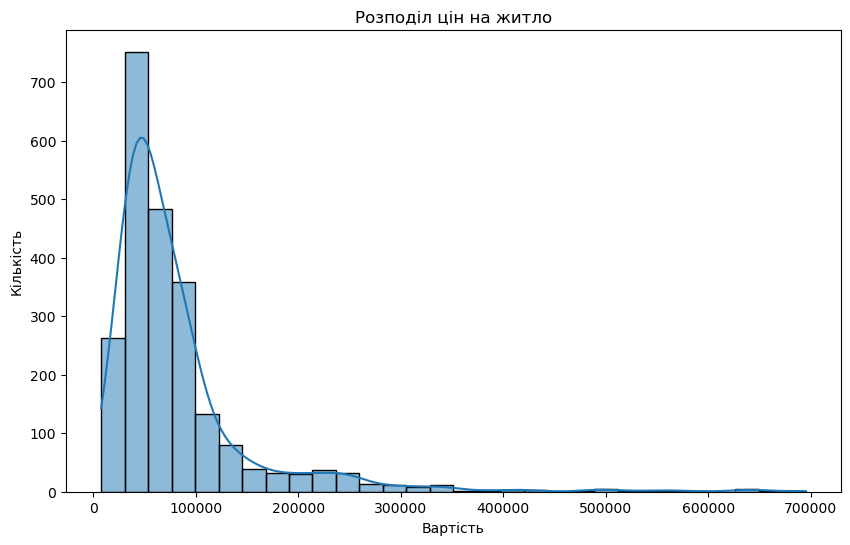

In [22]:
plt.figure(figsize=(10,6))
# Гістограма з лінією оцінки щільності
sns.histplot(data["Вартість"], bins=30, kde=True)
plt.title("Розподіл цін на житло")
plt.xlabel("Вартість")
plt.ylabel("Кількість")
plt.show()